# AIN313 - Machine Learning Course Project
# Student Name: Emirhan Utku , Student ID: 2210765029
# Student Name: Süleyman Yolcu , Student ID: 2210765016
# Date: November 10 , 2024
---


In [1]:
!pip list

Package                       Version
----------------------------- --------------------
alabaster                     0.7.12
anaconda-client               1.11.0
anaconda-navigator            2.3.2
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
applaunchservices             0.3.0
appnope                       0.1.2
appscript                     1.1.2
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.2
astroid                       2.11.7
astropy                       5.1
atomicwrites                  1.4.0
attrs                         21.4.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
bcrypt                        3.2.0
beautifulsoup4                4.11.1
bi

## Preprocessing Steps for injuries_2010-2020.csv

*When we examine our dataset, we need to understand which part of the body is injured from the 'Notes' column for the project we will do, but since information such as 'placed IL' does not provide us with any information, we removed the rows that have this information in this preprocessing stage.*

### Step 1: Filter Rows with Injury-Related Notes

In this step, we will filter out rows in our dataset based on the `Notes` column. We aim to:

1. Remove rows where the `Notes` column does not mention injuries.
2. Exclude rows that indicate activation, return, or other non-injury-related activities.

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from PIL import Image
from wordcloud import WordCloud
import re

# For preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Evaluation Metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# For handling missing values
from sklearn.impute import SimpleImputer

# For saving the model (Optional)
import joblib

# For text processing
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
injuries_df = pd.read_csv('injuries_2010-2020.csv')
injuries_df.head(100)

,Date,Team,Acquired,Relinquished,Notes
0,2010-10-03,Bulls,NaN,Carlos Boozer,fractured bone in right pinky finger (out inde...
1,2010-10-06,Pistons,NaN,Jonas Jerebko,torn right Achilles tendon (out indefinitely)
2,2010-10-06,Pistons,NaN,Terrico White,broken fifth metatarsal in right foot (out ind...
3,2010-10-08,Blazers,NaN,Jeff Ayres,torn ACL in right knee (out indefinitely)
4,2010-10-08,Nets,NaN,Troy Murphy,strained lower back (out indefinitely)
...,...,...,...,...,...
95,2010-10-28,Magic,NaN,Daniel Orton,placed on IL
96,2010-10-28,Magic,NaN,Malik Allen,placed on IL
97,2010-10-28,Spurs,NaN,Matt Bonner,sprained right ankle (DTD)
98,2010-10-28,Wizards,NaN,Gilbert Arenas,placed on IL with sprained right ankle


In [4]:
non_injury_keywords = ['activated', 'returned', 'lineup', 'cleared', 'ready']

injuries_df = injuries_df[
    ~injuries_df['Notes'].str.contains('|'.join(non_injury_keywords), case=False, na=False)
]

**Remove rows where Notes exactly say vague entries like 'placed on IL'**

In [5]:
def is_vague_il_entry(note):
    note = note.lower()
    return note.strip() in ['placed on il', 'placed on inactive']

injuries_df = injuries_df[
    ~injuries_df['Notes'].apply(is_vague_il_entry)
]

In [6]:
display(injuries_df.head(100))

,Date,Team,Acquired,Relinquished,Notes
0,2010-10-03,Bulls,NaN,Carlos Boozer,fractured bone in right pinky finger (out inde...
1,2010-10-06,Pistons,NaN,Jonas Jerebko,torn right Achilles tendon (out indefinitely)
2,2010-10-06,Pistons,NaN,Terrico White,broken fifth metatarsal in right foot (out ind...
3,2010-10-08,Blazers,NaN,Jeff Ayres,torn ACL in right knee (out indefinitely)
4,2010-10-08,Nets,NaN,Troy Murphy,strained lower back (out indefinitely)
...,...,...,...,...,...
202,2010-11-06,Raptors,NaN,Sonny Weems,placed on IL with ankle injury
204,2010-11-06,Rockets,NaN,Kyle Lowry,placed on IL with sore back
205,2010-11-06,Rockets,NaN,Yao Ming,placed on IL with foot injury / rest
209,2010-11-07,76ers,NaN,Andre Iguodala,placed on IL with right Achilles tendon injury


### Step 2: Extracting Injury Types

In this step, we will perform the following actions:

1. **Define a list of common injury-related keywords**:
   - Create a predefined list of keywords related to injuries (e.g., "fracture," "sprain," "laceration," etc.).

2. **Scan the Notes column of the filtered dataset**:
   - Examine the `Notes` column of the dataset for any matches with the defined keywords.

3. **Extract matches and create a new column**:
   - Add a new column to the dataset named `Injury_Type` to store the extracted keywords.


In [7]:
injury_keywords = [
    'knee', 'shoulder', 'hip', 'ankle', 'elbow', 'foot', 'heel', 'hand',
    'hamstring', 'back', 'groin', 'neck', 'head', 'wrist', 'calf', 'leg',
    'concussion', 'achilles', 'thigh', 'tibia', 'toe', 'adductor', 'chest',
    'nose', 'forearm', 'gluteus', 'eye', 'patella', 'quadricap', 'rib',
    'shin', 'pelvis', 'kneecap', 'orbital', 'thumb', 'spinal cord',
    'tailbone', 'cervical', 'cornea', 'cheekbone', 'collar bone', 'jaw',
    'flexor', 'forehead', 'fibula', 'oral', 'facial', 'abdominal',
    'abdomen', 'heart', 'throat', 'quadricep', 'oblique', 'finger',
    'hernia', 'abductor', 'tricep', 'bicep', 'lat', 'lung', 'face',
    'biceps', 'triceps', 'pectoral', 'plantar', 'disc'
]

def extract_injury_type(notes, keywords):
    injuries = [keyword for keyword in keywords if keyword in notes.lower()]

    return ', '.join(injuries)

injuries_df['Injury_Type'] = injuries_df['Notes'].apply(
    lambda x: extract_injury_type(x, injury_keywords)
)
injuries_df['Injury_Type'] = injuries_df['Injury_Type'].apply(
    lambda x: 'Other' if x == '' else x
)

display(injuries_df.head(100))

,Date,Team,Acquired,Relinquished,Notes,Injury_Type
0,2010-10-03,Bulls,NaN,Carlos Boozer,fractured bone in right pinky finger (out inde...,finger
1,2010-10-06,Pistons,NaN,Jonas Jerebko,torn right Achilles tendon (out indefinitely),achilles
2,2010-10-06,Pistons,NaN,Terrico White,broken fifth metatarsal in right foot (out ind...,foot
3,2010-10-08,Blazers,NaN,Jeff Ayres,torn ACL in right knee (out indefinitely),knee
4,2010-10-08,Nets,NaN,Troy Murphy,strained lower back (out indefinitely),back
...,...,...,...,...,...,...
202,2010-11-06,Raptors,NaN,Sonny Weems,placed on IL with ankle injury,ankle
204,2010-11-06,Rockets,NaN,Kyle Lowry,placed on IL with sore back,back
205,2010-11-06,Rockets,NaN,Yao Ming,placed on IL with foot injury / rest,foot
209,2010-11-07,76ers,NaN,Andre Iguodala,placed on IL with right Achilles tendon injury,achilles


In [8]:
injuries_df['Injury_Type'].value_counts()

knee                2499
ankle               2117
Other               2095
back                 922
hamstring            636
                    ... 
foot, leg              1
head, concussion       1
tibia, shin            1
back, hernia           1
shoulder, neck         1
Name: Injury_Type, Length: 181, dtype: int64

### Step 3: Classifying Injury Severity

In this step, we will classify injuries based on severity using the following approach:

1. **Identify severity indicators**:
   - Search for phrases such as "out indefinitely" or "out for season" in the `Notes` column to indicate severe injuries.

2. **Create a new column**:
   - Add a column named `Out_Indefinitely` with values:
     - `1` for severe injuries (indicated by the presence of severity phrases).
     - `0` for less serious injuries.

In [9]:
severity_keywords = ['out indefinitely', 'out for season']

injuries_df['Out_Indefinitely'] = injuries_df['Notes'].str.contains(
    '|'.join(severity_keywords), case=False, na=False
).astype(int)

In [10]:
injuries_df.head(100)

,Date,Team,Acquired,Relinquished,Notes,Injury_Type,Out_Indefinitely
0,2010-10-03,Bulls,NaN,Carlos Boozer,fractured bone in right pinky finger (out inde...,finger,1
1,2010-10-06,Pistons,NaN,Jonas Jerebko,torn right Achilles tendon (out indefinitely),achilles,1
2,2010-10-06,Pistons,NaN,Terrico White,broken fifth metatarsal in right foot (out ind...,foot,1
3,2010-10-08,Blazers,NaN,Jeff Ayres,torn ACL in right knee (out indefinitely),knee,1
4,2010-10-08,Nets,NaN,Troy Murphy,strained lower back (out indefinitely),back,1
...,...,...,...,...,...,...,...
202,2010-11-06,Raptors,NaN,Sonny Weems,placed on IL with ankle injury,ankle,0
204,2010-11-06,Rockets,NaN,Kyle Lowry,placed on IL with sore back,back,0
205,2010-11-06,Rockets,NaN,Yao Ming,placed on IL with foot injury / rest,foot,0
209,2010-11-07,76ers,NaN,Andre Iguodala,placed on IL with right Achilles tendon injury,achilles,0


### Step 4: Categorizing Injuries into Broader Body Part Categories

In this step, we will categorize injuries into broader body part categories. This additional step enhances exploratory analysis and modeling by providing higher-level insights into injury trends.

#### Benefits of Categorization:
1. **Summarize Insights**:
   - Allows easier analysis of trends in injuries across different body parts.
2. **Improve Modeling**:
   - Reduces noise from overly granular injury types, enabling models to identify broader patterns.

#### Implementation Steps:

1. **Define Body Part Categories**:
   - Group injuries into categories such as "Head", "Upper Body", "Lower Body", etc.
   - Map specific injury-related keywords to these categories.

2. **Create a Mapping Function**:
   - Use a function to assign injuries from the `Injury_Type` column to the defined body part categories.

3. **Add a New Column**:
   - Create a new column named `Body_Part_Category` to store the broader injury category for each row.
  

In [11]:
def categorize_injury(injury):
    if injury in ['hand', 'wrist', 'thumb', 'finger']:
        return 'Hand'
    elif injury in ['facial', 'jaw', 'cheekbone', 'orbital', 'nose', 'eye', 'oral', 'cornea', 'forehead', 'throat', 'face']:
        return 'Facial'
    elif injury in ['back', 'spinal cord', 'tailbone']:
        return 'Back'
    elif injury in ['leg', 'thigh', 'tibia', 'shin', 'quadricep', 'hamstring', 'knee', 'patella', 'kneecap', 'calf', 'achilles', 'adductor', 'fibula', 'ankle']:
        return 'Leg'
    elif injury in ['plantar', 'foot', 'heel', 'toe']:
        return 'Foot'
    elif injury in ['forearm', 'elbow', 'arm', 'tricep', 'bicep', 'biceps', 'triceps', 'flexor']:
        return 'Arm'
    elif injury in ['shoulder', 'chest', 'collarbone', 'rib', 'abdominal', 'abdomen', 'heart', 'lung', 'pectoral', 'disc']:
        return 'Upper Body'
    elif injury in ['hip', 'groin', 'pelvis', 'gluteus', 'quadricap']:
        return 'Lower Body'
    elif injury in ['head', 'concussion', 'neck', 'cervical']:
        return 'Head'
    else:
        return 'Others'


injuries_df['Body_Part'] = injuries_df['Injury_Type'].apply(
    lambda x: categorize_injury(x.split(', ')[0]) if x != 'Other' else 'Others'
)




In [12]:
injuries_df.head(100)

,Date,Team,Acquired,Relinquished,Notes,Injury_Type,Out_Indefinitely,Body_Part
0,2010-10-03,Bulls,NaN,Carlos Boozer,fractured bone in right pinky finger (out inde...,finger,1,Hand
1,2010-10-06,Pistons,NaN,Jonas Jerebko,torn right Achilles tendon (out indefinitely),achilles,1,Leg
2,2010-10-06,Pistons,NaN,Terrico White,broken fifth metatarsal in right foot (out ind...,foot,1,Foot
3,2010-10-08,Blazers,NaN,Jeff Ayres,torn ACL in right knee (out indefinitely),knee,1,Leg
4,2010-10-08,Nets,NaN,Troy Murphy,strained lower back (out indefinitely),back,1,Back
...,...,...,...,...,...,...,...,...
202,2010-11-06,Raptors,NaN,Sonny Weems,placed on IL with ankle injury,ankle,0,Leg
204,2010-11-06,Rockets,NaN,Kyle Lowry,placed on IL with sore back,back,0,Back
205,2010-11-06,Rockets,NaN,Yao Ming,placed on IL with foot injury / rest,foot,0,Foot
209,2010-11-07,76ers,NaN,Andre Iguodala,placed on IL with right Achilles tendon injury,achilles,0,Leg


In [13]:
injuries_df['Body_Part'].value_counts()

Leg           6842
Others        2148
Foot          1025
Back           953
Lower Body     826
Hand           795
Upper Body     748
Head           446
Arm            201
Facial         186
Name: Body_Part, dtype: int64

### Step 5: Categorizing Injuries into Broader Body Part Categories

In this step, we will categorize injuries into broader body part categories. This additional step enhances exploratory analysis and modeling by providing higher-level insights into injury trends.

#### Benefits of Categorization:
1. **Summarize Insights**:
   - Allows easier analysis of trends in injuries across different body parts.
2. **Improve Modeling**:
   - Reduces noise from overly granular injury types, enabling models to identify broader patterns.

#### Implementation Steps:

1. **Define Body Part Categories**:
   - Group injuries into categories such as "Head", "Upper Body", "Lower Body", etc.
   - Map specific injury-related keywords to these categories.

2. **Create a Mapping Function**:
   - Use a function to assign injuries from the `Injury_Type` column to the defined body part categories.

3. **Add a New Column**:
   - Create a new column named `Body_Part_Category` to store the broader injury category for each row.




In [14]:
injuries_df['Date'] = pd.to_datetime(injuries_df['Date'], errors='coerce')


def categorize_season(date):
    seasons = [
        ('10-11', pd.Timestamp('2010-10-03'), pd.Timestamp('2011-12-24')),
        ('11-12', pd.Timestamp('2011-12-25'), pd.Timestamp('2012-10-29')),
        ('12-13', pd.Timestamp('2012-10-30'), pd.Timestamp('2013-10-28')),
        ('13-14', pd.Timestamp('2013-10-29'), pd.Timestamp('2014-10-27')),
        ('14-15', pd.Timestamp('2014-10-28'), pd.Timestamp('2015-10-26')),
        ('15-16', pd.Timestamp('2015-10-27'), pd.Timestamp('2016-10-24')),
        ('16-17', pd.Timestamp('2016-10-25'), pd.Timestamp('2017-10-16')),
        ('17-18', pd.Timestamp('2017-10-17'), pd.Timestamp('2018-10-15')),
        ('18-19', pd.Timestamp('2018-10-16'), pd.Timestamp('2019-10-21')),
        ('19-20', pd.Timestamp('2019-10-22'), pd.Timestamp('2020-12-21')),
        ('20-21', pd.Timestamp('2020-12-22'), pd.Timestamp('2021-10-18'))
    ]


    for season, start, end in seasons:
        if start <= date <= end:
            return season


    return None


injuries_df['Season'] = injuries_df['Date'].apply(categorize_season)



In [15]:
injuries_df.head(100)

,Date,Team,Acquired,Relinquished,Notes,Injury_Type,Out_Indefinitely,Body_Part,Season
0,2010-10-03,Bulls,NaN,Carlos Boozer,fractured bone in right pinky finger (out inde...,finger,1,Hand,10-11
1,2010-10-06,Pistons,NaN,Jonas Jerebko,torn right Achilles tendon (out indefinitely),achilles,1,Leg,10-11
2,2010-10-06,Pistons,NaN,Terrico White,broken fifth metatarsal in right foot (out ind...,foot,1,Foot,10-11
3,2010-10-08,Blazers,NaN,Jeff Ayres,torn ACL in right knee (out indefinitely),knee,1,Leg,10-11
4,2010-10-08,Nets,NaN,Troy Murphy,strained lower back (out indefinitely),back,1,Back,10-11
...,...,...,...,...,...,...,...,...,...
202,2010-11-06,Raptors,NaN,Sonny Weems,placed on IL with ankle injury,ankle,0,Leg,10-11
204,2010-11-06,Rockets,NaN,Kyle Lowry,placed on IL with sore back,back,0,Back,10-11
205,2010-11-06,Rockets,NaN,Yao Ming,placed on IL with foot injury / rest,foot,0,Foot,10-11
209,2010-11-07,76ers,NaN,Andre Iguodala,placed on IL with right Achilles tendon injury,achilles,0,Leg,10-11


## Understanding Preprocessed 'injuries_2010-2020.csv' Data

## Word Cloud and Bar Chart Analysis

### Key Findings:

1. **Word Cloud Observations**:
   - Words like "right," "left," "placed," and "on" dominate the word cloud. These are commonly used in descriptions of injuries or player status updates (e.g., "placed on IL with right knee strain").
   - Injury-specific terms such as "knee," "ankle," "sore," "strained," "foot," and "injury" are prominent, emphasizing the dataset's injury-focused nature.
   - Contextual words like "indefinitely," "DNP" (Did Not Play), and "season" stand out, reflecting injury severity and game impact.

2. **General Observations**:
   - Generic terms like "on," "with," and "placed" contribute to the word count but offer limited insights. Removing such words (stopwords) in future iterations would make the visualization more meaningful.
   - The prominence of specific injury-related terms (e.g., "ankle," "sprained," "knee") aligns with the dataset's focus and provides a clear understanding of frequent injuries.

---

### Bar Chart of Top 20 Most Common Words:

   - The most frequent words include "on," "placed," "left," and "right," reflecting the descriptive language in the dataset.
   - Specific injury-related terms such as "knee," "ankle," "sprained," and "strained" are among the top terms, showing their prevalence in the data.
   - Words like "DNP" (Did Not Play) and "out" highlight the focus on player absences and severity classification.



---



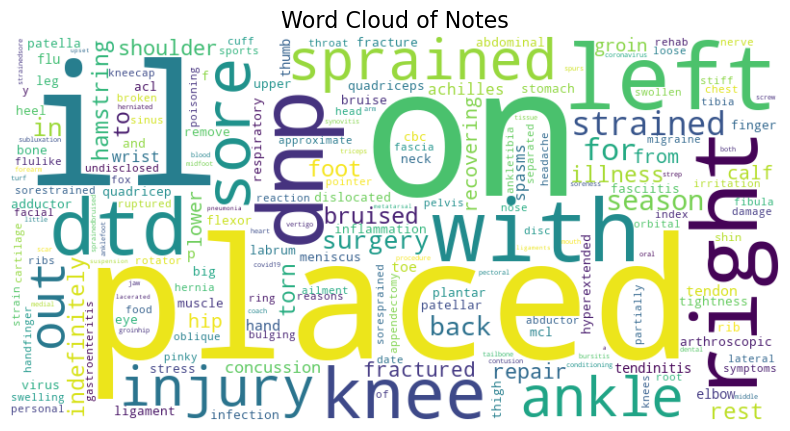

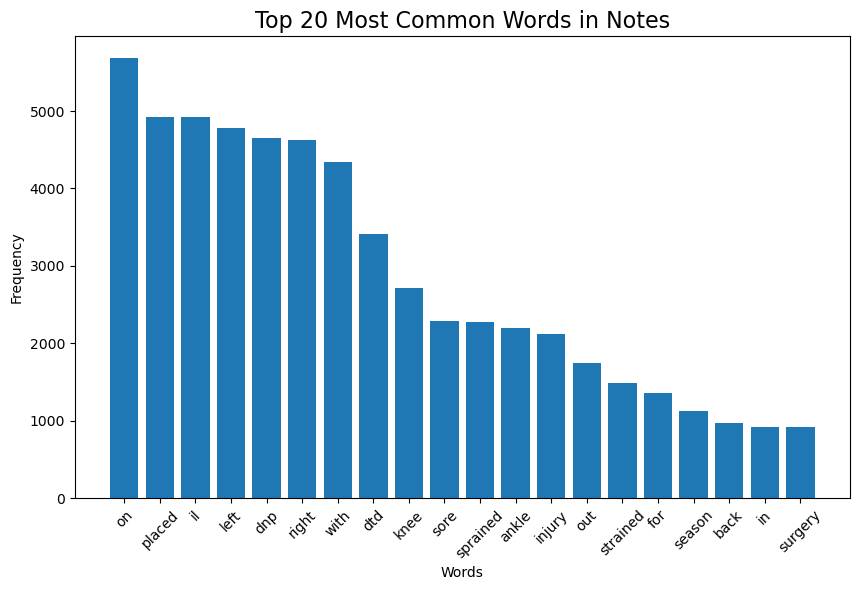

In [16]:
notes = injuries_df['Notes']

def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text.split()

all_words = [word for note in notes for word in preprocess_text(note)]

word_counts = Counter(all_words)

most_common_words = word_counts.most_common(20)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Notes', fontsize=16)
plt.show()

common_words, frequencies = zip(*most_common_words)
plt.figure(figsize=(10, 6))
plt.bar(common_words, frequencies)
plt.title('Top 20 Most Common Words in Notes', fontsize=16)
plt.ylabel('Frequency')
plt.xlabel('Words')
plt.xticks(rotation=45)
plt.show()


### Comments on N-Gram Analysis Results

#### Bigram Analysis

The bigram analysis highlights frequent procedural phrases like "placed il" and "activated il," which dominate the dataset but contribute little to injury analysis. In contrast, injury-specific bigrams such as "left knee," "right ankle," and "sprained left" emphasize injury localization and severity. Terms like "returned lineup" appear as status updates and could be filtered out to refine the focus.

Excluding procedural phrases and concentrating on injury-specific bigrams would provide actionable insights, such as identifying common injury patterns and localizations.

#### Trigram Analysis

The trigram analysis provides more detailed descriptions, with phrases like "sprained left ankle" and "right knee dnp" showing both injury types and their impact on gameplay. However, procedural phrases like "placed il sore" still dominate, reducing the focus on injuries.

Filtering out procedural trigrams and focusing on injury-related ones (e.g., "sprained left ankle") would enhance the analysis, enabling a deeper understanding of specific injuries and their correlation with gameplay metrics.

#### General Observations

While n-gram analysis effectively captures patterns like injury types, procedural phrases like "placed il" add noise. Implementing domain-specific filters to exclude these terms would improve relevance. Grouping related n-grams (e.g., ankle injuries) could help identify trends and correlations with other factors, such as workload or season timing.

Focusing on actionable n-grams, such as "sprained left ankle," can enhance predictive modeling and injury prevention strategies, making the analysis more impactful for practical applications.


In [17]:
def get_top_ngrams(corpus, ngram_range=(2, 2), top_n=20):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vectorizer.fit_transform(corpus)
    ngram_counts = X.sum(axis=0).A1
    ngram_features = vectorizer.get_feature_names_out()
    ngram_frequencies = dict(zip(ngram_features, ngram_counts))
    return Counter(ngram_frequencies).most_common(top_n)


common_bigrams = get_top_ngrams(notes, ngram_range=(2, 2), top_n=20)

common_trigrams = get_top_ngrams(notes, ngram_range=(3, 3), top_n=20)

common_bigrams, common_trigrams


([('placed il', 4914),
  ('left knee', 1286),
  ('right knee', 1180),
  ('left ankle', 1168),
  ('sprained left', 1145),
  ('sprained right', 1009),
  ('sore left', 954),
  ('right ankle', 888),
  ('sore right', 870),
  ('il sore', 783),
  ('il sprained', 762),
  ('ankle dnp', 709),
  ('strained left', 648),
  ('injury dtd', 624),
  ('knee dnp', 606),
  ('strained right', 584),
  ('knee injury', 465),
  ('il strained', 460),
  ('ankle dtd', 457),
  ('injury dnp', 434)],
 [('sprained left ankle', 888),
  ('placed il sore', 783),
  ('placed il sprained', 762),
  ('sprained right ankle', 624),
  ('placed il strained', 460),
  ('left ankle dnp', 447),
  ('sore left knee', 435),
  ('sore right knee', 381),
  ('il sprained left', 356),
  ('il sprained right', 335),
  ('left knee dnp', 302),
  ('il sore left', 298),
  ('il sore right', 298),
  ('right knee dnp', 296),
  ('placed il illness', 288),
  ('placed il right', 276),
  ('placed il left', 261),
  ('placed il bruised', 255),
  ('right a

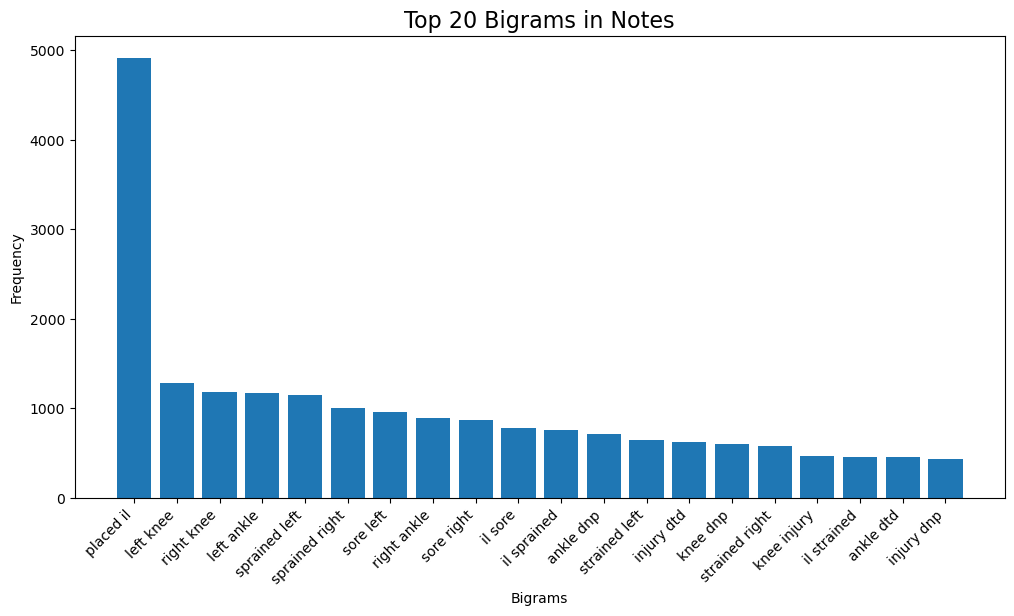

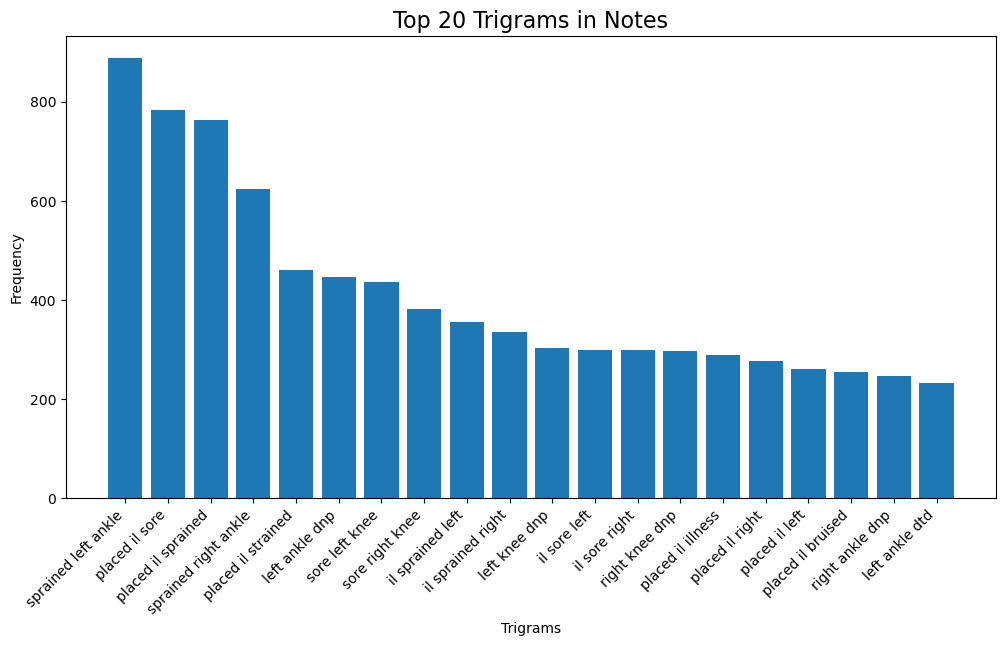

In [18]:
bigrams, bigram_freqs = zip(*common_bigrams)
trigrams, trigram_freqs = zip(*common_trigrams)

plt.figure(figsize=(12, 6))
plt.bar(bigrams, bigram_freqs)
plt.title('Top 20 Bigrams in Notes', fontsize=16)
plt.ylabel('Frequency')
plt.xlabel('Bigrams')
plt.xticks(rotation=45, ha='right')
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(trigrams, trigram_freqs)
plt.title('Top 20 Trigrams in Notes', fontsize=16)
plt.ylabel('Frequency')
plt.xlabel('Trigrams')
plt.xticks(rotation=45, ha='right')
plt.show()

In [19]:
# Filter the injuries dataset for seasons 2013-2020 and prepare for merging with in-game stats data
injuries_df = injuries_df[injuries_df['Season'].notna() & ~injuries_df['Season'].isin(['10-11', '11-12', '12-13'])].copy()


In [20]:
injuries_df

,Date,Team,Acquired,Relinquished,Notes,Injury_Type,Out_Indefinitely,Body_Part,Season
7514,2013-10-29,76ers,NaN,Jason Richardson,placed on IL recovering from surgery on left k...,knee,1,Leg,13-14
7515,2013-10-29,76ers,NaN,Nerlens Noel,placed on IL recovering from surgery on left k...,knee,1,Leg,13-14
7516,2013-10-29,Bucks,NaN,Carlos Delfino,recovering from surgery on right foot (out ind...,foot,1,Foot,13-14
7517,2013-10-29,Cavaliers,NaN,Carrick Felix,sports hernia (out indefinitely),hernia,1,Others,13-14
7518,2013-10-29,Celtics,NaN,Rajon Rondo,recovering from surgery on left knee to repair...,knee,1,Leg,13-14
...,...,...,...,...,...,...,...,...,...
27097,2020-09-22,Celtics,NaN,Romeo Langford,surgery on right wrist (out for season),wrist,1,Hand,19-20
27098,2020-09-23,Heat,NaN,Gabe Vincent,sore right knee (DTD),knee,0,Leg,19-20
27099,2020-09-30,Heat,NaN,Bam Adebayo,strained left shoulder (DTD),shoulder,0,Upper Body,19-20
27101,2020-10-02,Heat,NaN,Bam Adebayo,strained neck (DTD),neck,0,Head,19-20


In [21]:
stats_df = pd.read_csv('stats_2013-2023.csv')
stats_df.head()

,PLAYER_ID,PLAYER_NAME,SEASON,SEASON_NUM,AGE,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT,GP,MIN,USG_PCT,...,AVG_SEC_PER_TOUCH,AVG_DRIB_PER_TOUCH,ELBOW_TOUCHES,POST_TOUCHES,PAINT_TOUCHES,TEAM,INJURED ON,RETURNED,DAYS MISSED,INJURED_TYPE
0,1630639,A.J. Lawson,22-23,22.5,22.0,78,179,13,4.8,0.182,...,1.39,0.62,0.0,0.0,0.2,NaN,NaN,NaN,NaN,NaN
1,1631260,AJ Green,22-23,22.5,23.0,77,190,32,9.4,0.160,...,2.61,1.84,0.1,0.0,0.3,NaN,NaN,NaN,NaN,NaN
2,1631100,AJ Griffin,22-23,22.5,19.0,78,220,66,19.4,0.174,...,2.08,1.49,0.4,0.0,0.7,NaN,NaN,NaN,NaN,NaN
3,203932,Aaron Gordon,22-23,22.5,27.0,80,235,61,30.1,0.206,...,2.94,2.11,1.8,2.1,6.8,Nuggets,2023-02-02,2023-02-07,5.0,Sprained_ankle
4,1628988,Aaron Holiday,22-23,22.5,26.0,72,185,57,13.7,0.128,...,4.17,3.82,0.1,0.0,0.4,NaN,NaN,NaN,NaN,NaN


In [22]:
# Filter out unwanted seasons from df_gamestats
stats_df = stats_df[~stats_df['SEASON'].isin(['20-21', '21-22', '22-23', '23-24'])].copy()


In [23]:
stats_df

,PLAYER_ID,PLAYER_NAME,SEASON,SEASON_NUM,AGE,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT,GP,MIN,USG_PCT,...,AVG_SEC_PER_TOUCH,AVG_DRIB_PER_TOUCH,ELBOW_TOUCHES,POST_TOUCHES,PAINT_TOUCHES,TEAM,INJURED ON,RETURNED,DAYS MISSED,INJURED_TYPE
1851,203932,Aaron Gordon,19-20,19.5,24.0,80,235,62,32.5,0.205,...,2.88,1.91,1.8,3.2,4.3,NaN,NaN,NaN,NaN,NaN
1852,1628988,Aaron Holiday,19-20,19.5,23.0,72,185,66,24.5,0.182,...,4.35,4.17,0.1,0.0,0.3,NaN,NaN,NaN,NaN,NaN
1853,1627846,Abdel Nader,19-20,19.5,26.0,77,225,55,15.8,0.164,...,2.05,1.41,0.2,0.0,0.4,Thunder,2020-01-15,2020-01-29,14.0,Sprained_ankle
1854,1629690,Adam Mokoka,19-20,19.5,21.0,77,190,11,10.2,0.110,...,1.47,0.83,0.2,0.0,0.8,NaN,NaN,NaN,NaN,NaN
1855,1629678,Admiral Schofield,19-20,19.5,23.0,77,241,33,11.2,0.118,...,1.40,0.51,0.2,0.2,0.6,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5573,2584,Willie Green,13-14,13.5,32.0,75,201,55,15.8,0.162,...,2.44,1.84,0.5,0.1,0.5,NaN,NaN,NaN,NaN,NaN
5574,201163,Wilson Chandler,13-14,13.5,27.0,80,225,62,31.1,0.193,...,2.33,1.26,1.4,1.0,1.7,NaN,NaN,NaN,NaN,NaN
5575,202333,Xavier Henry,13-14,13.5,23.0,78,220,43,21.1,0.223,...,3.24,2.45,0.9,0.1,1.2,NaN,NaN,NaN,NaN,NaN
5576,2216,Zach Randolph,13-14,13.5,32.0,81,260,79,34.2,0.258,...,2.15,0.81,3.6,17.3,9.5,NaN,NaN,NaN,NaN,NaN


In [24]:
# We merged the datasets by left join the player in-game stats table
# using player names, seasons, and teams as unique keys
merged_df = pd.merge(stats_df, injuries_df, how = 'left', left_on=['PLAYER_NAME', 'SEASON', 'TEAM'], right_on=['Relinquished', 'Season', 'Team'])


In [25]:
merged_df.columns

Index(['PLAYER_ID', 'PLAYER_NAME', 'SEASON', 'SEASON_NUM', 'AGE',
       'PLAYER_HEIGHT_INCHES', 'PLAYER_WEIGHT', 'GP', 'MIN', 'USG_PCT', 'PACE',
       'POSS', 'FGA_PG', 'DRIVES', 'DRIVE_FGA', 'DRIVE_PASSES', 'DIST_MILES',
       'AVG_SPEED', 'PULL_UP_FGA', 'PULL_UP_FG3A', 'TOUCHES',
       'FRONT_CT_TOUCHES', 'AVG_SEC_PER_TOUCH', 'AVG_DRIB_PER_TOUCH',
       'ELBOW_TOUCHES', 'POST_TOUCHES', 'PAINT_TOUCHES', 'TEAM', 'INJURED ON',
       'RETURNED', 'DAYS MISSED', 'INJURED_TYPE', 'Date', 'Team', 'Acquired',
       'Relinquished', 'Notes', 'Injury_Type', 'Out_Indefinitely', 'Body_Part',
       'Season'],
      dtype='object')

In [26]:
# Clean the merged_df by dropping duplicated entry
merged_df_cleaned = merged_df.drop_duplicates(subset = ['SEASON_NUM', 'Injury_Type', 'Out_Indefinitely', 'PLAYER_NAME', 'Team'])


In [27]:
selected_columns = ['PLAYER_NAME', 'SEASON', 'SEASON_NUM', 'AGE', 'PLAYER_HEIGHT_INCHES',
                    'PLAYER_WEIGHT', 'GP', 'MIN', 'Notes', 
                    'Injury_Type', 'Out_Indefinitely', 'Body_Part']

# Display the selected columns
merged_df_cleaned_selected = merged_df_cleaned[selected_columns]

# Print the resulting DataFrame
display(merged_df_cleaned_selected)

,PLAYER_NAME,SEASON,SEASON_NUM,AGE,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT,GP,MIN,Notes,Injury_Type,Out_Indefinitely,Body_Part
0,Aaron Gordon,19-20,19.5,24.0,80,235,62,32.5,NaN,NaN,NaN,NaN
1,Aaron Holiday,19-20,19.5,23.0,72,185,66,24.5,NaN,NaN,NaN,NaN
2,Abdel Nader,19-20,19.5,26.0,77,225,55,15.8,sprained left ankle (DTD),ankle,0.0,Leg
4,Abdel Nader,19-20,19.5,26.0,77,225,55,15.8,placed on IL with neck injury,neck,0.0,Head
5,Adam Mokoka,19-20,19.5,21.0,77,190,11,10.2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
6141,Willie Green,13-14,13.5,32.0,75,201,55,15.8,NaN,NaN,NaN,NaN
6142,Wilson Chandler,13-14,13.5,27.0,80,225,62,31.1,NaN,NaN,NaN,NaN
6143,Xavier Henry,13-14,13.5,23.0,78,220,43,21.1,NaN,NaN,NaN,NaN
6144,Zach Randolph,13-14,13.5,32.0,81,260,79,34.2,NaN,NaN,NaN,NaN


In [28]:
clean_list = ['PLAYER_ID', 'Acquired', 'Relinquished', 'Season']
merged_df_cleaned = merged_df_cleaned.drop(columns = clean_list, index = 1)

In [29]:
merged_df_cleaned.columns

Index(['PLAYER_NAME', 'SEASON', 'SEASON_NUM', 'AGE', 'PLAYER_HEIGHT_INCHES',
       'PLAYER_WEIGHT', 'GP', 'MIN', 'USG_PCT', 'PACE', 'POSS', 'FGA_PG',
       'DRIVES', 'DRIVE_FGA', 'DRIVE_PASSES', 'DIST_MILES', 'AVG_SPEED',
       'PULL_UP_FGA', 'PULL_UP_FG3A', 'TOUCHES', 'FRONT_CT_TOUCHES',
       'AVG_SEC_PER_TOUCH', 'AVG_DRIB_PER_TOUCH', 'ELBOW_TOUCHES',
       'POST_TOUCHES', 'PAINT_TOUCHES', 'TEAM', 'INJURED ON', 'RETURNED',
       'DAYS MISSED', 'INJURED_TYPE', 'Date', 'Team', 'Notes', 'Injury_Type',
       'Out_Indefinitely', 'Body_Part'],
      dtype='object')

In [30]:
merged_df_cleaned.shape

(4273, 37)

### Feature extraction for EDA

In [31]:
# Out Indefinitely Dummy
merged_df_cleaned['Out_Indefinitely'].fillna(False, inplace=True)
merged_df_cleaned['Out_Indefinitely'] = [1 if x == True else 0 for x in merged_df_cleaned['Out_Indefinitely']]

In [32]:
merged_df_cleaned['Year'] = merged_df_cleaned['Date'].dt.year
merged_df_cleaned['Month'] = merged_df_cleaned['Date'].dt.month

# Injury indicator column
merged_df_cleaned['Injured'] = np.where(merged_df_cleaned['Injury_Type'].notna(), 1, 0)


In [33]:
# Turn columns into numerical
numeric_columns = ['PLAYER_HEIGHT_INCHES', 'GP', 'PLAYER_WEIGHT', 'POSS', 'DIST_MILES', 'AVG_SPEED', 'PULL_UP_FG3A']
for col in numeric_columns:
  merged_df_cleaned[col] = pd.to_numeric(merged_df_cleaned[col], errors='coerce')

# 2. Data Visualization and EDA

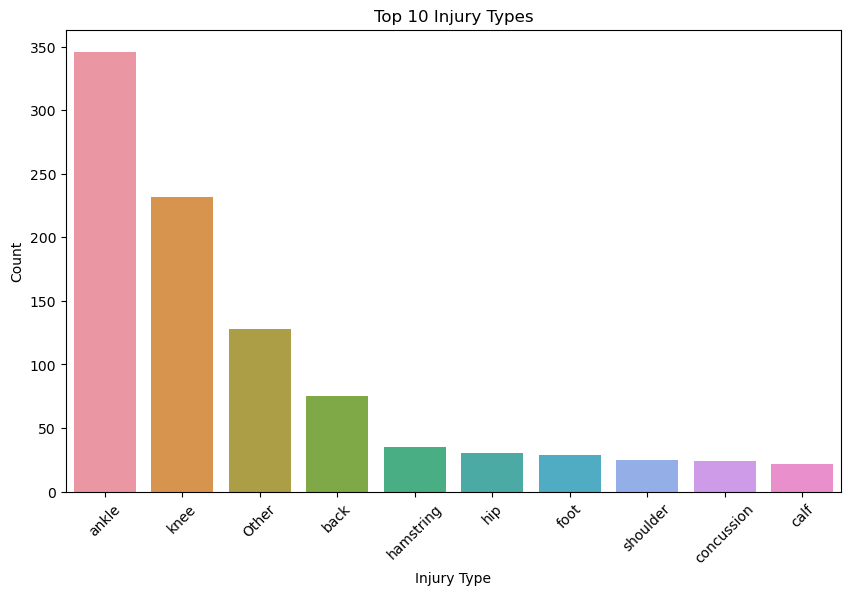

In [34]:
plt.style.use('seaborn-dark-palette')
injury_counts = merged_df_cleaned['Injury_Type'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=injury_counts.index, y=injury_counts.values)
plt.xticks(rotation=45)
plt.title('Top 10 Injury Types')
plt.xlabel('Injury Type')
plt.ylabel('Count')
plt.show()


### Top 10 Injury Types

*The analysis found that ankle and knee injuries were the most common types, with ankle injuries being the most common type with over 350 incidents. This suggests that lower-body injuries are a significant concern, particularly in high-impact or dynamic sports. Back and hamstring injuries are also common, emphasizing the physical strain on the core and lower body. Concussions, while less common, remain critical due to their potential long-term effects. These findings highlight the importance of targeted injury prevention strategies, particularly for the lower body.*

---


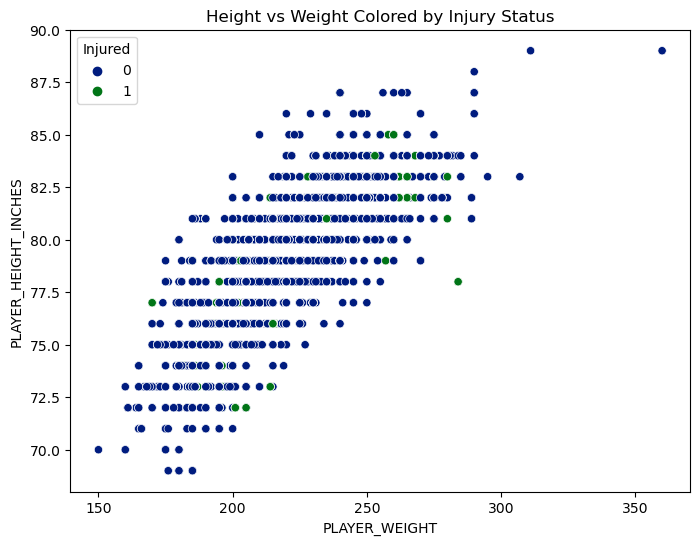

In [35]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='PLAYER_WEIGHT', y='PLAYER_HEIGHT_INCHES', hue='Injured', data=merged_df_cleaned)
plt.title('Height vs Weight Colored by Injury Status')
plt.show()

### Height vs Weight Colored by Injury Status

*The scatterplot shows the distribution of player height and weight, with points colored by injury status. Players who sustained injuries are marked in green, while non-injured players are in blue. The visualization highlights that injuries are distributed across various height and weight ranges, with no clear concentration in any specific range. This suggests that while height and weight may contribute to injury risk, they are not the sole determining factors. Further analysis incorporating additional variables, such as playing position or workload, might provide more insights into injury patterns.*

---

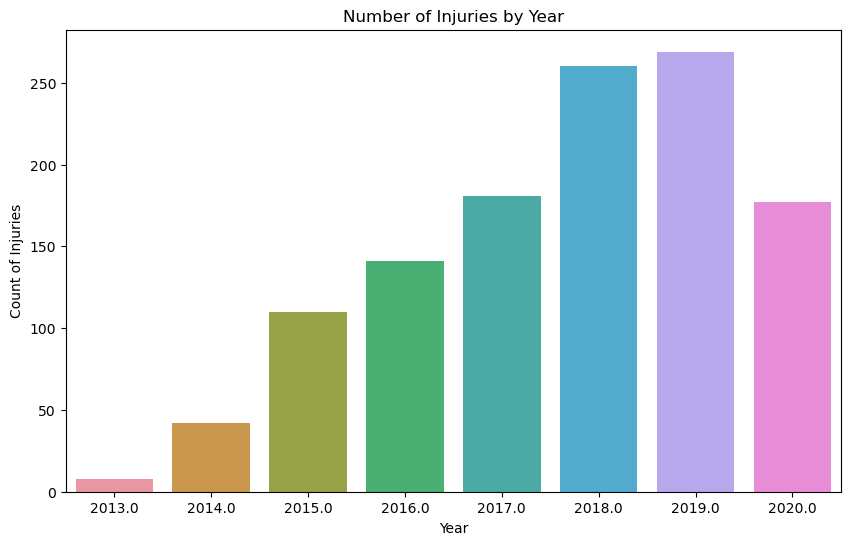

In [36]:
year_counts = merged_df_cleaned[merged_df_cleaned['Injured'] == 1]['Year'].value_counts().sort_index()
plt.figure(figsize=(10,6))
sns.barplot(x=year_counts.index, y=year_counts.values)
plt.title('Number of Injuries by Year')
plt.xlabel('Year')
plt.ylabel('Count of Injuries')
plt.show()

### Number of Injuries by Year

*This bar chart displays the annual distribution of injuries from 2013 to 2020. A noticeable increase in injuries occurs between 2015 and 2019, with 2018 and 2019 showing the highest counts. The drop in 2020 may be attributed to the shortened season or interruptions caused by external factors, such as the COVID-19 pandemic. The trend suggests a potential rise in injury risk over time, possibly due to increased game intensity, scheduling demands, or other factors requiring further exploration.*

---

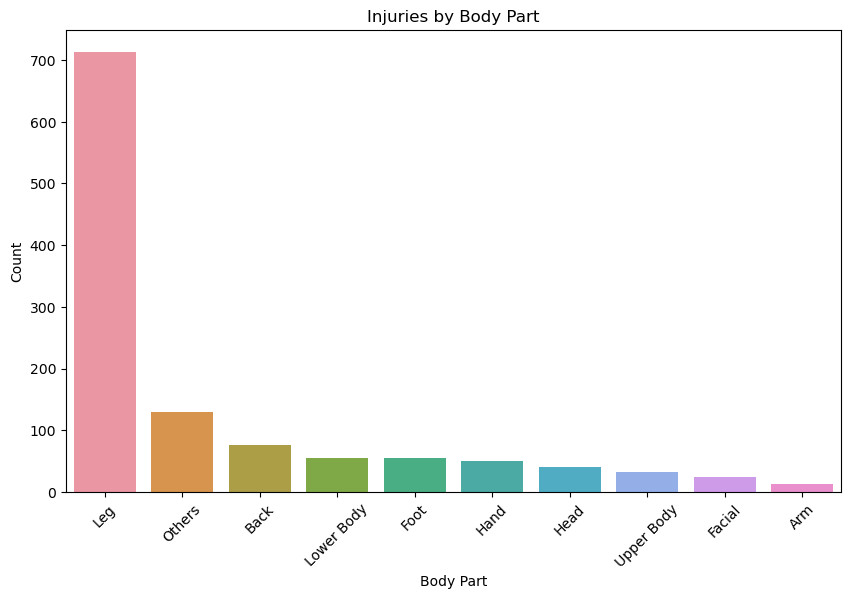

In [37]:
body_part_counts = merged_df_cleaned['Body_Part'].value_counts()
plt.figure(figsize=(10,6))
sns.barplot(x=body_part_counts.index, y=body_part_counts.values)
plt.xticks(rotation=45)
plt.title('Injuries by Body Part')
plt.xlabel('Body Part')
plt.ylabel('Count')
plt.show()

### Injuries by Body Part

*The chart reveals that leg injuries are overwhelmingly the most common, with over 700 recorded cases, reflecting the significant strain placed on the lower body during athletic activities like running, jumping, and pivoting. Other notable categories include back and lower body injuries, which are also frequent but occur far less than leg injuries. Categories such as hand, head, and upper body injuries are less common, though their presence indicates the diverse range of injuries athletes experience. The "Others" category highlights injuries that don't fit predefined labels, demonstrating the complexity of injury reporting. Overall, the dominance of leg injuries suggests a need for focused prevention and rehabilitation strategies for lower-body injuries in sports.*

---


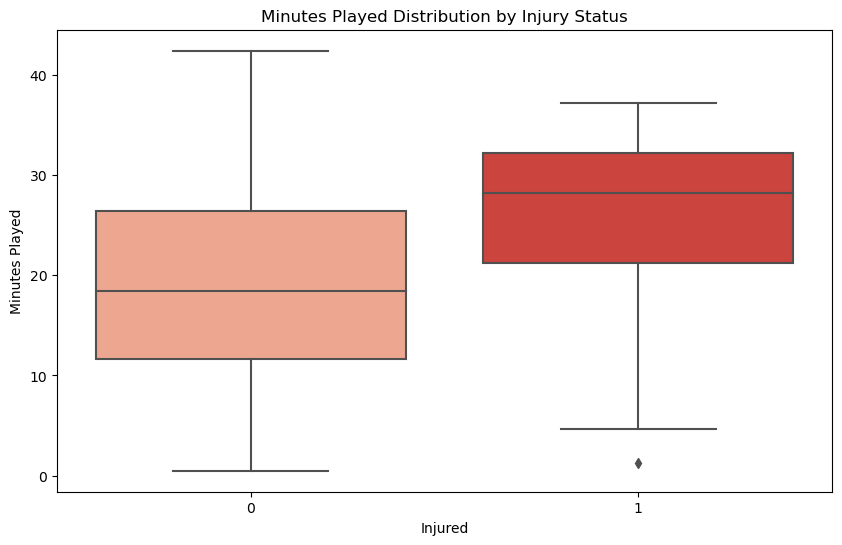

In [38]:
plt.figure(figsize=(10,6))
sns.boxplot(x='Injured', y='MIN', data=merged_df_cleaned, palette='Reds')
plt.title('Minutes Played Distribution by Injury Status')
plt.xlabel('Injured')
plt.ylabel('Minutes Played')
plt.show()


### Minutes Played Distribution by Injury Status

*The boxplot illustrates the distribution of minutes played for injured and non-injured players. Players who experienced injuries generally played more minutes on average compared to non-injured players, as shown by the higher median and interquartile range for injured individuals. This finding suggests that higher workloads, represented by more minutes played, may correlate with a greater likelihood of injuries. Additionally, the wider spread of data among injured players indicates variability in how playing time impacts injury risks, with some players logging significantly high minutes before sustaining injuries. This insight emphasizes the importance of monitoring player workload to prevent overuse injuries.*

---


In [39]:
out_indef_count = merged_df_cleaned['Out_Indefinitely'].sum()
total_injuries = merged_df_cleaned['Injured'].sum()
percentage_out_indef = (out_indef_count / total_injuries) * 100
print(f"Percentage of injuries leading to Out Indefinitely: {percentage_out_indef:.2f}%")


Percentage of injuries leading to Out Indefinitely: 12.29%


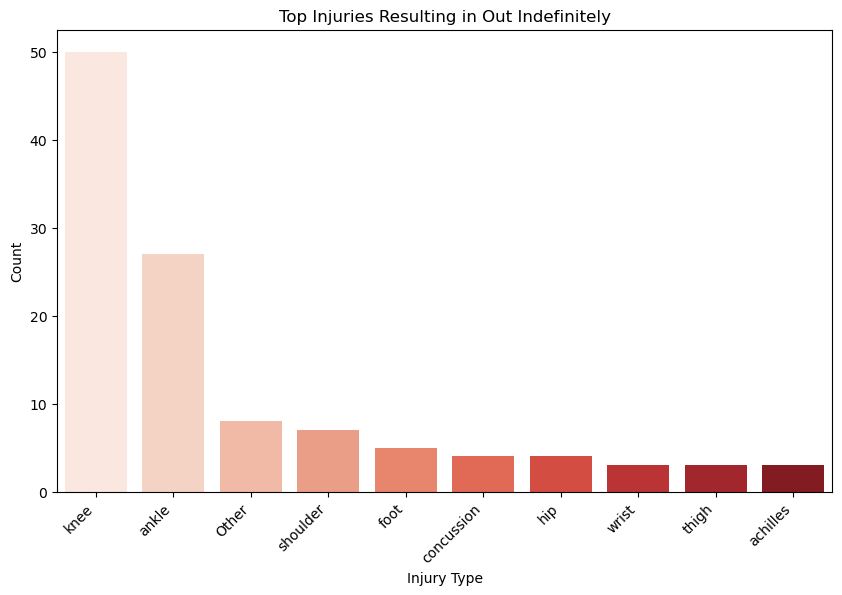

In [40]:
severity_injuries = merged_df_cleaned[merged_df_cleaned['Out_Indefinitely'] == 1]['Injury_Type'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=severity_injuries.index, y=severity_injuries.values, palette='Reds')
plt.title('Top Injuries Resulting in Out Indefinitely')
plt.xlabel('Injury Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

### Top Injuries Resulting in "Out Indefinitely"

This bar chart highlights the injury types most associated with players being labeled as "out indefinitely." Knee injuries are by far the leading cause, followed by ankle injuries, which collectively account for a significant proportion of long-term absences. While shoulder injuries are only the 8th most common overall, they rank as the 4th most likely to result in indefinite absences, indicating their severity. The percentage of all injuries leading to "out indefinitely" is 12.29%, emphasizing the importance of injury type when evaluating the risk of extended recovery periods. This insight underlines the need for targeted prevention strategies for high-risk injuries like those to the knee and shoulder.

----


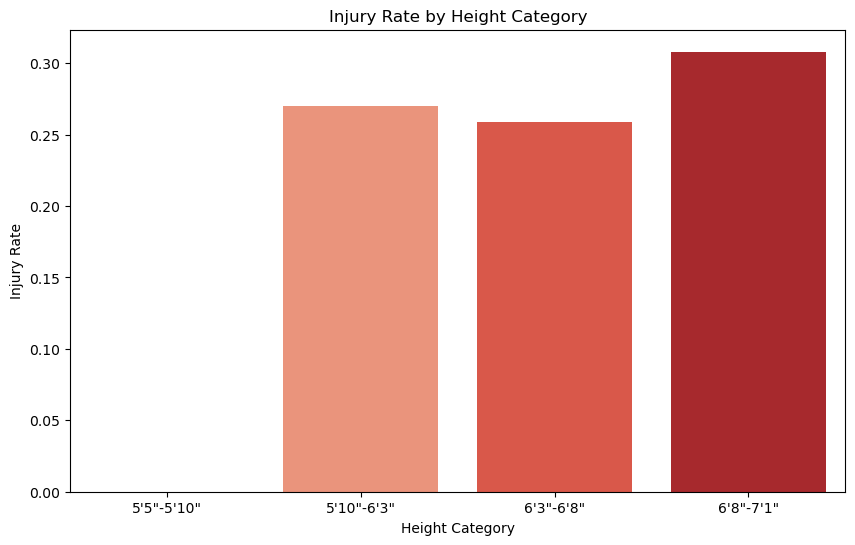

In [41]:
merged_df_cleaned['Height_Bin'] = pd.cut(merged_df_cleaned['PLAYER_HEIGHT_INCHES'], bins=[65,70,75,80,85], labels=['5\'5"-5\'10"', '5\'10"-6\'3"', '6\'3"-6\'8"', '6\'8"-7\'1"'])
height_injury_rate = merged_df_cleaned.groupby('Height_Bin')['Injured'].mean().dropna()
plt.figure(figsize=(10,6))
sns.barplot(x=height_injury_rate.index, y=height_injury_rate.values, palette='Reds')
plt.title('Injury Rate by Height Category')
plt.xlabel('Height Category')
plt.ylabel('Injury Rate')
plt.show()

### Injury Rate by Height Category

*The bar chart shows the injury rate across different height categories. Players in the tallest height range, 6'8" to 7'1", have the highest injury rate, surpassing 30%. This trend suggests that taller players may face greater physical strain or are involved in more intense play styles, leading to higher injury risks. Players in the mid-height ranges (5'10"–6'3" and 6'3"–6'8") show moderately high injury rates, while shorter players (5'5"–5'10") have the lowest injury rates. These findings imply a possible relationship between player height and susceptibility to injuries, warranting further investigation into factors like role, playstyle, and workload for taller athletes.*

---

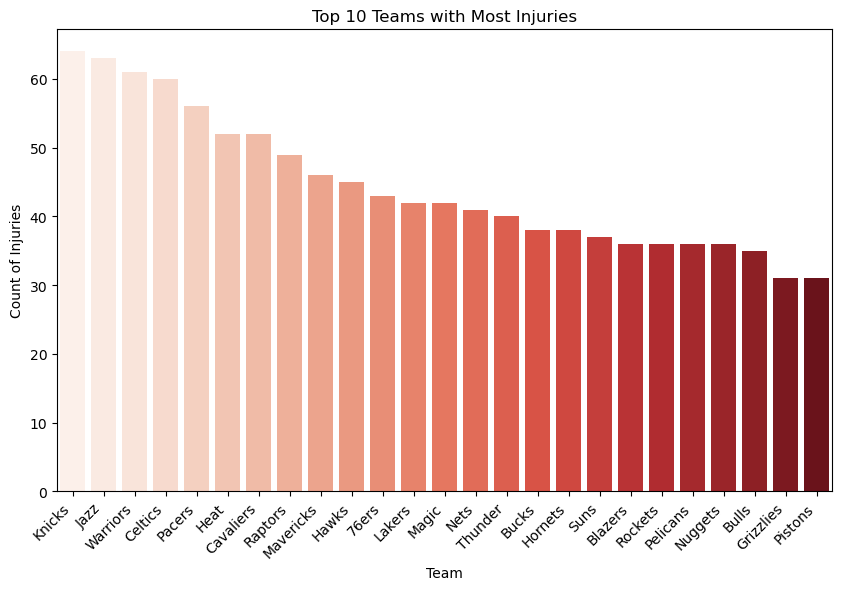

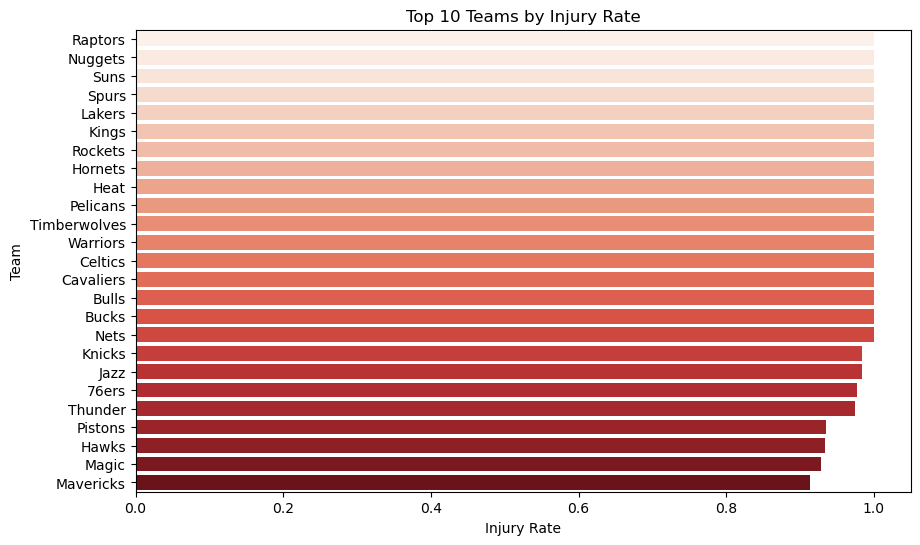

In [42]:
team_injury_counts = merged_df_cleaned['TEAM'].value_counts().head(25)
plt.figure(figsize=(10,6))
sns.barplot(x=team_injury_counts.index, y=team_injury_counts.values, palette='Reds')
plt.title('Top 10 Teams with Most Injuries')
plt.xlabel('Team')
plt.ylabel('Count of Injuries')
plt.xticks(rotation=45, ha='right')
plt.show()

# Compare injury rates among teams
team_injury_rate = merged_df_cleaned.groupby('TEAM')['Injured'].mean().sort_values(ascending=False).head(25)
plt.figure(figsize=(10,6))
sns.barplot(x=team_injury_rate.values, y=team_injury_rate.index, palette='Reds', orient='h')
plt.title('Top 10 Teams by Injury Rate')
plt.xlabel('Injury Rate')
plt.ylabel('Team')
plt.show()

### Analysis of Team-Based Injury Trends

*The first bar chart highlights the **top 10 teams with the most injuries** during the analyzed seasons. The **New York Knicks**, **Utah Jazz**, and **Golden State Warriors** lead the list with over 60 reported injuries each. These results may be influenced by team playstyle, medical staff efficiency, or even random variance, which could be investigated further. The chart provides valuable insights for teams aiming to reduce injuries by learning from their counterparts with fewer incidents.*

*The second bar chart shifts the focus to **injury rate per team**—the proportion of injured players relative to total players. Interestingly, teams like the **Raptors** and **Pelicans** rank highest in injury rates, even though they do not have the absolute highest number of injuries. This metric offers a normalized perspective, enabling comparisons across teams of different sizes. For example, while the Knicks lead in raw injury counts, the Pelicans' high injury rate signals a larger issue relative to their team size.*

*These visualizations together underline that injury prevention strategies may differ depending on whether the focus is on minimizing absolute injuries or lowering the injury rate relative to the team roster.*

---


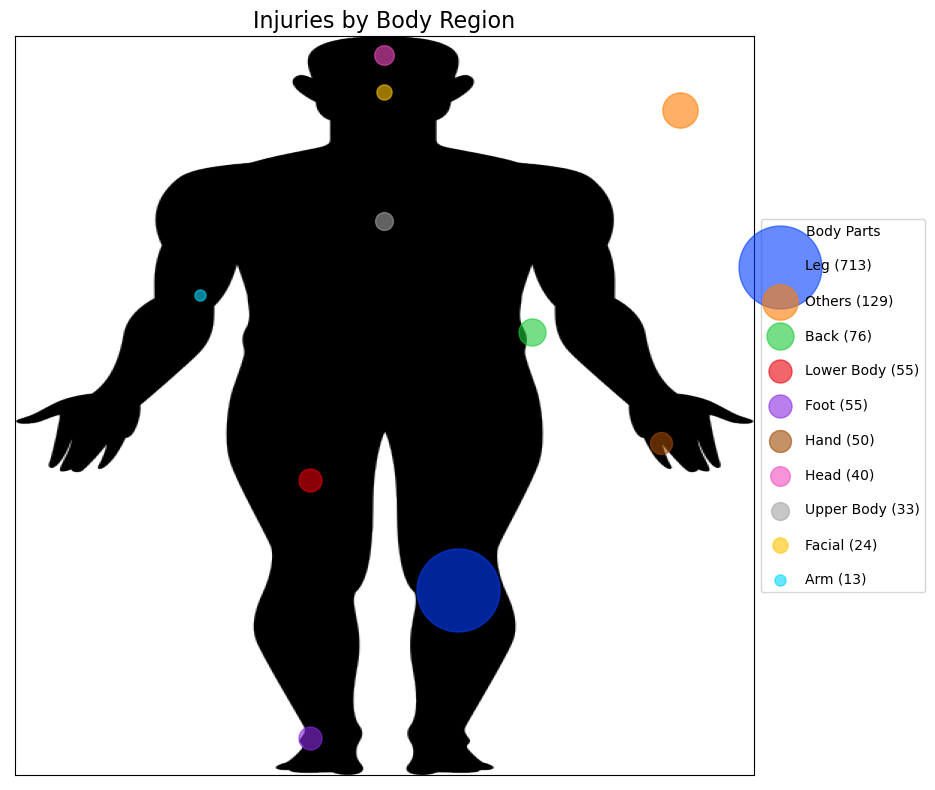

In [43]:
# Count occurrences of each body part in the dataset
body_part_counts = merged_df_cleaned['Body_Part'].value_counts()

# Load the body image to overlay the data visualization
body_image = Image.open('body_image.png')
fig, ax = plt.subplots(figsize=(16, 8))

# Set the background as the body image
ax.imshow(body_image, extent=[0, 20, 0, 20])

# Dynamically generate a color palette based on the number of unique body parts
color_palette = sns.color_palette("bright", n_colors=len(body_part_counts))

# Define approximate locations for body parts on the image
body_part_positions = {
    'Lower Body': (8, 8),
    'Leg': (12, 5),
    'Others': (18, 18),
    'Back': (14, 12),
    'Foot': (8, 1),
    'Hand': (17.5, 9),
    'Head': (10, 19.5),
    'Upper Body': (10, 15),
    'Facial': (10, 18.5),
    'Arm': (5, 13)
}

# Add scatter points to represent injury counts for each body part
for idx, (body_part, count) in enumerate(body_part_counts.items()):
    position = body_part_positions.get(body_part, (0, 0))  # Fallback to (0, 0) if body part not found
    ax.scatter(*position, s=count * 5, label=f'{body_part} ({count})', alpha=0.6, color=color_palette[idx])

# Configure plot settings
ax.set_title('Injuries by Body Region', fontsize=16)
ax.set_xticks([])
ax.set_yticks([])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Body Parts', labelspacing=1.5)
ax.set_aspect('equal')
ax.grid(False)

plt.tight_layout()
plt.show()


### Comment on Body Part Injury Visualization

*This visualization provides a clear and intuitive representation of injury distribution across different body parts. It highlights that leg injuries are the most frequent, represented by the largest circle on the leg area, which is expected given the physical demands on the lower body in sports. Other notable injury areas include the back, hand, and head, though their frequency is significantly lower.  The use of circle size and color coding makes it easy to compare injury prevalence across body parts.*

---


In [44]:
merged_df_cleaned

,PLAYER_NAME,SEASON,SEASON_NUM,AGE,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT,GP,MIN,USG_PCT,PACE,...,Date,Team,Notes,Injury_Type,Out_Indefinitely,Body_Part,Year,Month,Injured,Height_Bin
0,Aaron Gordon,19-20,19.5,24.0,80.0,235.0,62,32.5,0.205,99.72,...,NaT,NaN,NaN,NaN,0,NaN,NaN,NaN,0,"6'3""-6'8"""
2,Abdel Nader,19-20,19.5,26.0,77.0,225.0,55,15.8,0.164,101.79,...,2020-01-14,Thunder,sprained left ankle (DTD),ankle,0,Leg,2020.0,1.0,1,"6'3""-6'8"""
4,Abdel Nader,19-20,19.5,26.0,77.0,225.0,55,15.8,0.164,101.79,...,2020-08-14,Thunder,placed on IL with neck injury,neck,0,Head,2020.0,8.0,1,"6'3""-6'8"""
5,Adam Mokoka,19-20,19.5,21.0,77.0,190.0,11,10.2,0.110,100.37,...,NaT,NaN,NaN,NaN,0,NaN,NaN,NaN,0,"6'3""-6'8"""
6,Admiral Schofield,19-20,19.5,23.0,77.0,241.0,33,11.2,0.118,103.13,...,NaT,NaN,NaN,NaN,0,NaN,NaN,NaN,0,"6'3""-6'8"""
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6141,Willie Green,13-14,13.5,32.0,75.0,201.0,55,15.8,0.162,98.46,...,NaT,NaN,NaN,NaN,0,NaN,NaN,NaN,0,"5'10""-6'3"""
6142,Wilson Chandler,13-14,13.5,27.0,80.0,225.0,62,31.1,0.193,99.49,...,NaT,NaN,NaN,NaN,0,NaN,NaN,NaN,0,"6'3""-6'8"""
6143,Xavier Henry,13-14,13.5,23.0,78.0,220.0,43,21.1,0.223,101.48,...,NaT,NaN,NaN,NaN,0,NaN,NaN,NaN,0,"6'3""-6'8"""
6144,Zach Randolph,13-14,13.5,32.0,81.0,260.0,79,34.2,0.258,90.59,...,NaT,NaN,NaN,NaN,0,NaN,NaN,NaN,0,"6'8""-7'1"""


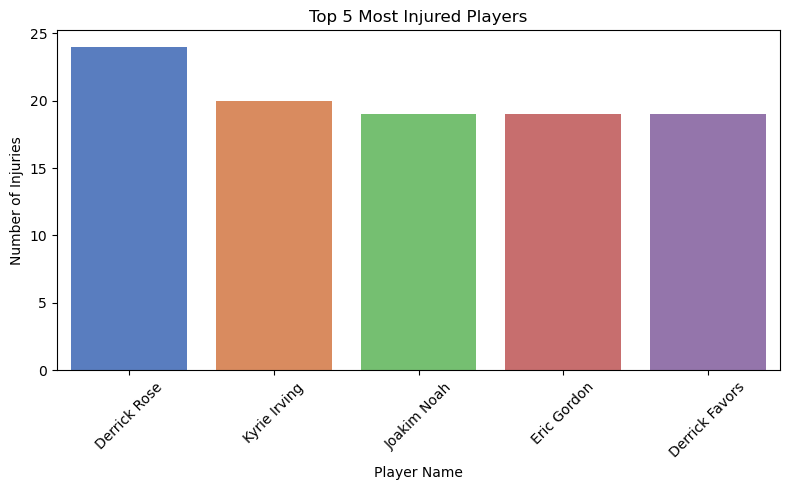

In [45]:

excluded_seasons = ['10-11', '11-12', '12-13']
excluded_player = 'C.J. Miles'

filtered_injuries_df = merged_df_cleaned[
    (~merged_df_cleaned['SEASON'].isin(excluded_seasons)) & 
    (merged_df_cleaned['PLAYER_NAME'] != excluded_player)
]


top_5_injured_players = (
    filtered_injuries_df['PLAYER_NAME']
    .value_counts()
    .head(5)
    .reset_index()
    .rename(columns={'index': 'PLAYER_NAME', 'PLAYER_NAME': 'Injury_Count'})
)




top_players_data = merged_df_cleaned[merged_df_cleaned['PLAYER_NAME'].isin(top_5_injured_players['PLAYER_NAME'])]

averaged_players_data = (
    top_players_data
    .groupby('PLAYER_NAME', as_index=False)  # PLAYER_NAME'e göre grupla
    .mean()  # Sayısal kolonların ortalamasını al
)





plt.figure(figsize=(8, 5))
sns.barplot(data=top_5_injured_players, x='PLAYER_NAME', y='Injury_Count', palette='muted')
plt.title('Top 5 Most Injured Players')
plt.xlabel('Player Name')
plt.ylabel('Number of Injuries')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




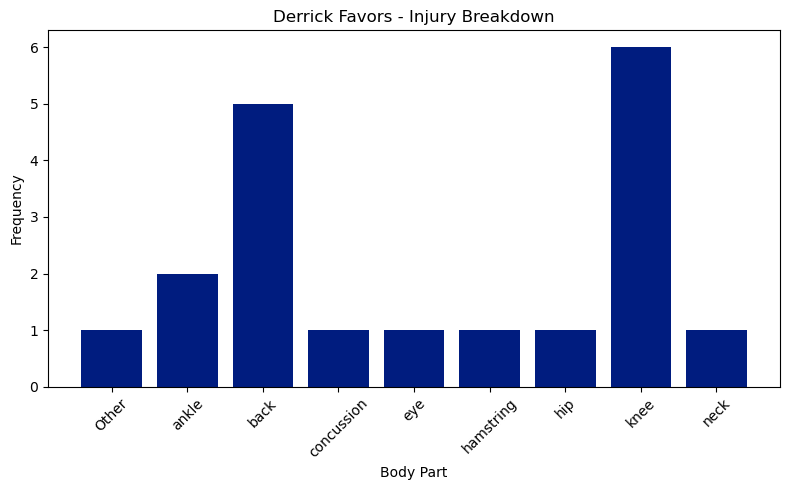

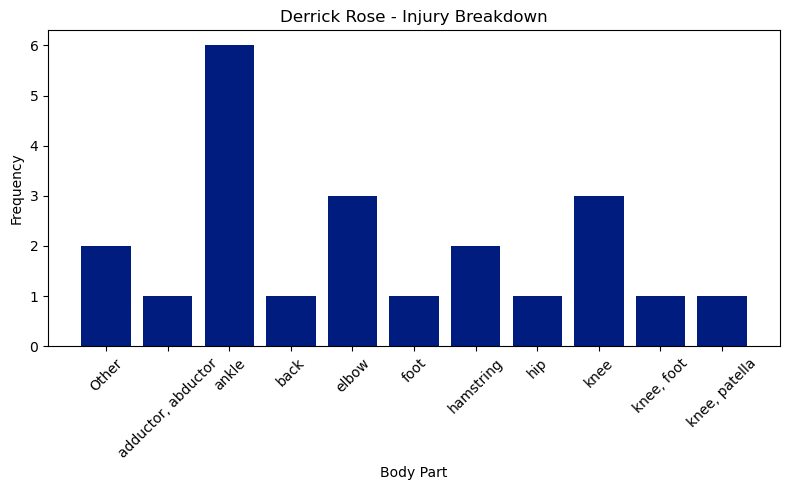

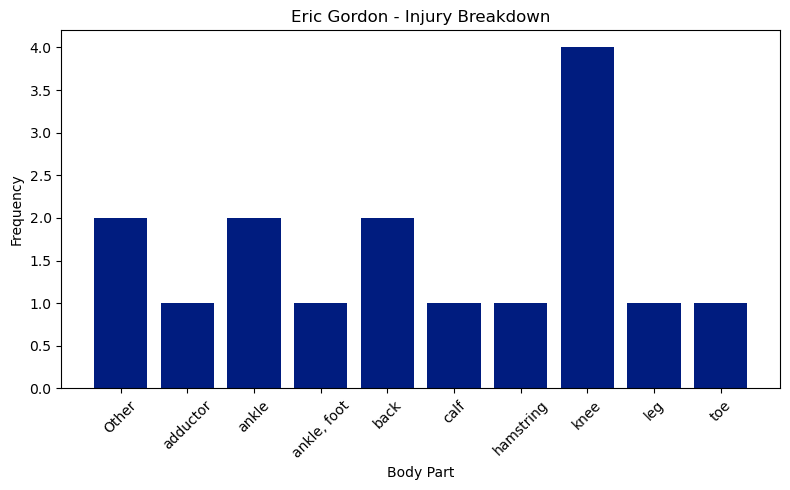

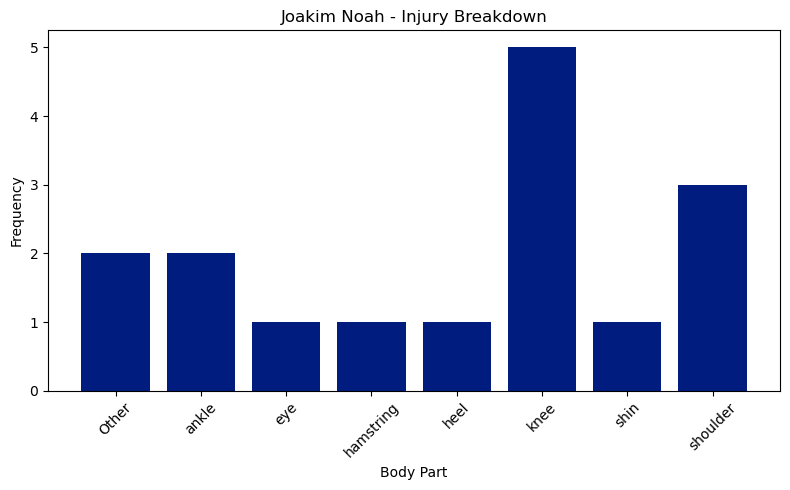

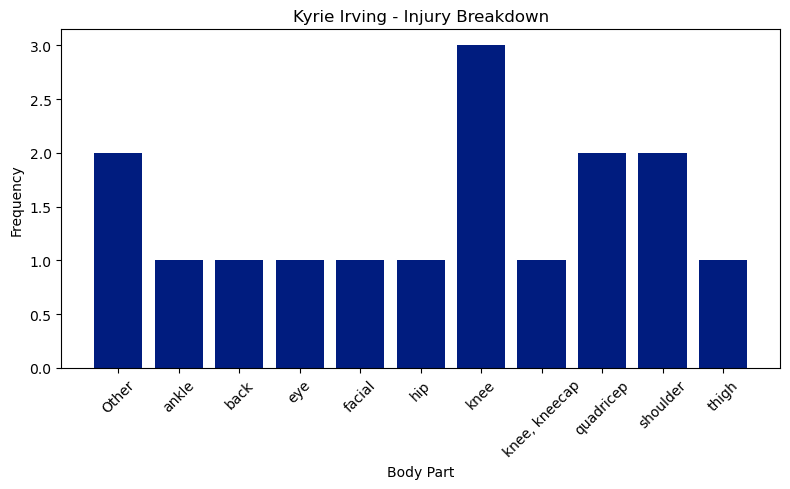

In [46]:
injured_players_data = top_players_data[top_players_data['Injured'] == 1]


player_injury_counts = (
    injured_players_data
    .groupby(['PLAYER_NAME', 'Injury_Type'])
    .size()  
    .reset_index(name='Injury_Count') 
)

for player in player_injury_counts['PLAYER_NAME'].unique():
    player_data = player_injury_counts[player_injury_counts['PLAYER_NAME'] == player]
    
    plt.figure(figsize=(8, 5))
    plt.bar(player_data['Injury_Type'], player_data['Injury_Count'])
    plt.title(f'{player} - Injury Breakdown')
    plt.xlabel('Body Part')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Injury Breakdown Analysis

### Derrick Favors
Derrick Favors shows a significant concentration of injuries in the **knee**, which accounts for the majority of his reported issues. Other frequent injury areas include the **back** and **ankle**, with minor occurrences in the **hip**, **neck**, and **hamstring**. This pattern suggests that Favors’ lower body, particularly his knees, is a key vulnerability, likely stemming from the physical demands of his position and his role in rebounding and defense.

### Derrick Rose
Derrick Rose's injury profile is dominated by **ankle** injuries, followed by significant occurrences in the **knee** and **elbow**. Other injuries are more spread out, affecting the **hamstring**, **back**, and **foot**. This distribution reflects the high-impact nature of Rose's playstyle, involving explosive movements and quick directional changes, which place immense stress on his lower body and joints.

### Eric Gordon
Eric Gordon also demonstrates a heavy concentration of injuries in the **knee**, making it the most frequently injured region. Additionally, injuries to the **ankle**, **back**, and **calf** are noteworthy. The spread of injuries across multiple regions points to the physical toll of Gordon's high-energy playing style, particularly on his lower extremities and supporting muscles.

### Joakim Noah
Joakim Noah has a distinct injury pattern centered on the **knee**, followed by the **shoulder**. Other affected areas include the **ankle**, **heel**, and **hamstring**, with minor occurrences in the **shin** and **eye**. Noah's injuries highlight the wear and tear associated with his aggressive defensive and rebounding playstyle, where both upper and lower body are under constant strain.

### Kyrie Irving
Kyrie Irving exhibits a diverse injury pattern, but the **knee** remains the most affected region. He also has notable injuries in the **ankle**, **shoulder**, and **hip**, with smaller contributions from areas like the **eye** and **back**. Irving’s history reflects the dynamic and contact-heavy nature of his guard position, where both lower and upper body are susceptible to injuries from quick movements and physical contact.

---

### Summary
Across the players analyzed, the **knee** emerges as the most commonly injured area, highlighting its critical role in basketball and the stress it endures. Players like Derrick Favors, Eric Gordon, and Joakim Noah experience concentrated lower-body injuries due to their size and physical playing styles. In contrast, guards like Derrick Rose and Kyrie Irving show a broader injury distribution but still display vulnerabilities in high-impact areas like the ankle and knee. Tailored injury prevention strategies focusing on lower-body conditioning and joint support are crucial for these players.


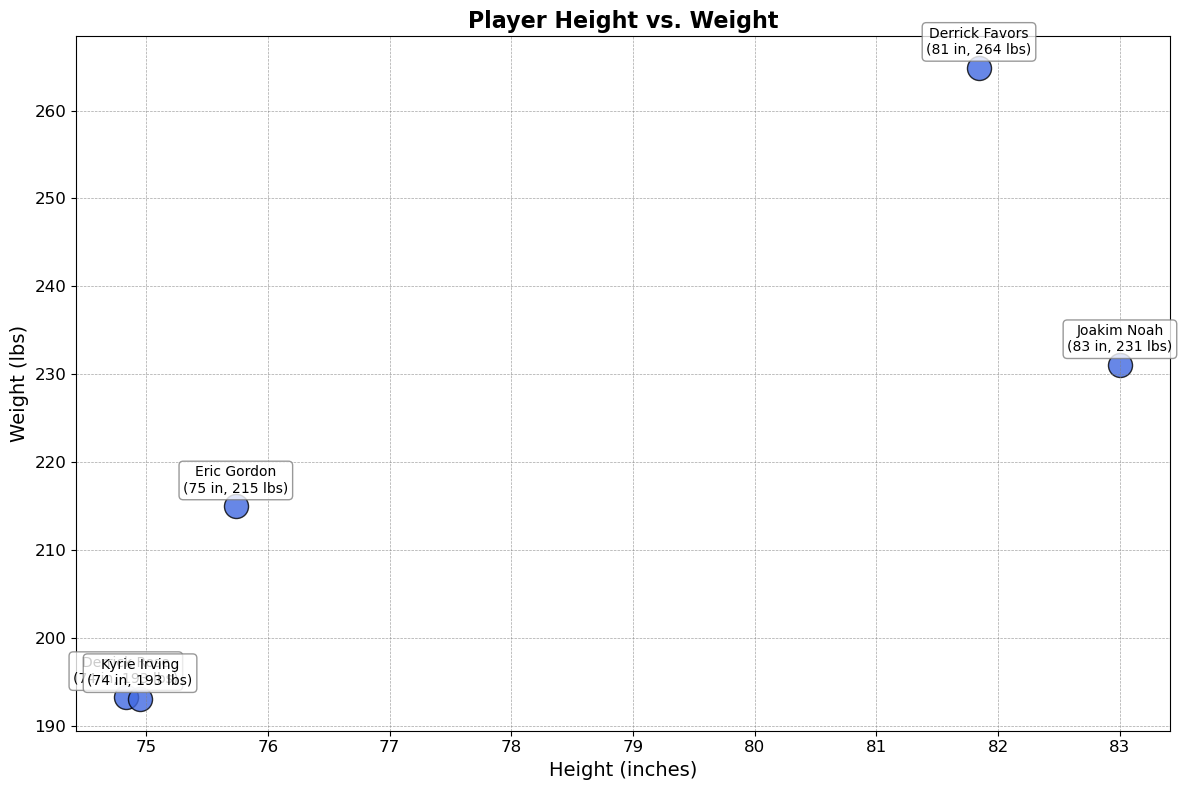

In [47]:
# Improved scatter plot for PLAYER_HEIGHT_INCHES vs PLAYER_WEIGHT
plt.figure(figsize=(12, 8))

# Scatter points with enhanced visuals
plt.scatter(
    averaged_players_data['PLAYER_HEIGHT_INCHES'], 
    averaged_players_data['PLAYER_WEIGHT'], 
    color='royalblue', 
    s=300,  # Larger marker size
    alpha=0.8,  # Slight transparency
    edgecolor='black'  # Add border to markers
)

# Annotate each point with the player's name and attributes
for i, row in averaged_players_data.iterrows():
    player_name = row['PLAYER_NAME']
    height = row['PLAYER_HEIGHT_INCHES']
    weight = row['PLAYER_WEIGHT']
    plt.annotate(
        f"{player_name}\n({int(height)} in, {int(weight)} lbs)",  # Clean formatting
        (height, weight),
        textcoords="offset points",
        xytext=(0, 10),  # Adjust annotation position
        ha='center',
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="gray", facecolor="white", alpha=0.8)  # Annotation box
    )

# Add labels, title, and grid
plt.title("Player Height vs. Weight", fontsize=16, fontweight='bold')
plt.xlabel("Height (inches)", fontsize=14)
plt.ylabel("Weight (lbs)", fontsize=14)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust tick parameters for better readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()


## Height, Weight, and Injury Analysis

### General Insights:
The relationship between player height, weight, and injury patterns is evident from the scatter plot and injury breakdowns. Taller and heavier players (e.g., Derrick Favors and Joakim Noah) exhibit injury concentrations in areas like the knee, reflecting the physical stress on lower-body joints due to their size and playing style. In contrast, shorter players like Kyrie Irving and Eric Gordon show more distributed injuries, influenced by the demands of quick movements and agility.

### Player-Specific Analysis:

- **Derrick Favors**:  
  At 81 inches and 264 lbs, Favors is one of the tallest and heaviest players. His injury profile is dominated by knee issues, indicating the significant load his frame places on his joints. The physical demands of rebounding and defending exacerbate stress on the lower body, particularly the knees and back.

- **Joakim Noah**:  
  Standing at 83 inches and weighing 231 lbs, Noah’s injury history also highlights vulnerabilities in the knee and shoulder. His height and leaner build compared to Favors suggest a slightly better weight distribution, but his aggressive playstyle still leads to wear and tear in high-stress areas like the knees.

- **Eric Gordon**:  
  At 75 inches and 215 lbs, Gordon is shorter and lighter than the big men but has a compact build that contributes to injuries in the knee, ankle, and back. His injury profile reflects the demands of his physical and energetic style of play, where quick bursts and impacts are frequent.

- **Kyrie Irving**:  
  As the shortest and lightest in the group (74 inches, 193 lbs), Irving’s injury distribution is more varied, with a focus on knees, shoulders, and other areas. His role as a guard necessitates constant cutting, pivoting, and absorbing contact, contributing to the broad spread of injuries.

### Conclusion:
The analysis shows a clear correlation between size and injury patterns:
- **Big men** like Derrick Favors and Joakim Noah face repetitive stress injuries in the lower body due to their height and weight.
- **Guards** like Kyrie Irving and Eric Gordon, while less prone to joint stress, are susceptible to diverse injuries due to the dynamic nature of their play.

This emphasizes the need for player-specific conditioning and injury prevention strategies to mitigate risks based on physical attributes and roles.


# 3. Model Building

In [48]:
merged_df_cleaned.head()

,PLAYER_NAME,SEASON,SEASON_NUM,AGE,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT,GP,MIN,USG_PCT,PACE,...,Date,Team,Notes,Injury_Type,Out_Indefinitely,Body_Part,Year,Month,Injured,Height_Bin
0,Aaron Gordon,19-20,19.5,24.0,80.0,235.0,62,32.5,0.205,99.72,...,NaT,NaN,NaN,NaN,0,NaN,NaN,NaN,0,"6'3""-6'8"""
2,Abdel Nader,19-20,19.5,26.0,77.0,225.0,55,15.8,0.164,101.79,...,2020-01-14,Thunder,sprained left ankle (DTD),ankle,0,Leg,2020.0,1.0,1,"6'3""-6'8"""
4,Abdel Nader,19-20,19.5,26.0,77.0,225.0,55,15.8,0.164,101.79,...,2020-08-14,Thunder,placed on IL with neck injury,neck,0,Head,2020.0,8.0,1,"6'3""-6'8"""
5,Adam Mokoka,19-20,19.5,21.0,77.0,190.0,11,10.2,0.110,100.37,...,NaT,NaN,NaN,NaN,0,NaN,NaN,NaN,0,"6'3""-6'8"""
6,Admiral Schofield,19-20,19.5,23.0,77.0,241.0,33,11.2,0.118,103.13,...,NaT,NaN,NaN,NaN,0,NaN,NaN,NaN,0,"6'3""-6'8"""


In [49]:
merged_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4273 entries, 0 to 6145
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   PLAYER_NAME           4273 non-null   object        
 1   SEASON                4273 non-null   object        
 2   SEASON_NUM            4273 non-null   float64       
 3   AGE                   4273 non-null   float64       
 4   PLAYER_HEIGHT_INCHES  4268 non-null   float64       
 5   PLAYER_WEIGHT         4268 non-null   float64       
 6   GP                    4273 non-null   int64         
 7   MIN                   4273 non-null   float64       
 8   USG_PCT               4273 non-null   float64       
 9   PACE                  4273 non-null   float64       
 10  POSS                  4273 non-null   int64         
 11  FGA_PG                4273 non-null   float64       
 12  DRIVES                4273 non-null   float64       
 13  DRIVE_FGA         

In [50]:
merged_df_cleaned.isnull().sum()

PLAYER_NAME                0
SEASON                     0
SEASON_NUM                 0
AGE                        0
PLAYER_HEIGHT_INCHES       5
PLAYER_WEIGHT              5
GP                         0
MIN                        0
USG_PCT                    0
PACE                       0
POSS                       0
FGA_PG                     0
DRIVES                     0
DRIVE_FGA                  0
DRIVE_PASSES               0
DIST_MILES                 1
AVG_SPEED                  1
PULL_UP_FGA                0
PULL_UP_FG3A             375
TOUCHES                    0
FRONT_CT_TOUCHES           0
AVG_SEC_PER_TOUCH          0
AVG_DRIB_PER_TOUCH         0
ELBOW_TOUCHES              0
POST_TOUCHES               0
PAINT_TOUCHES              0
TEAM                    3055
INJURED ON              3055
RETURNED                3055
DAYS MISSED             3055
INJURED_TYPE            3055
Date                    3085
Team                    3087
Notes                   3085
Injury_Type   

In [51]:
# List of columns to drop
columns_to_drop = [
    'PLAYER_NAME', 'SEASON', 'SEASON_NUM', 'TEAM', 'INJURED ON', 'RETURNED',
    'DAYS MISSED', 'INJURED_TYPE', 'Team', 'Notes', 'Out_Indefinitely',
    'Injury_Type', 'Body_Part', 'Date', 'Year', 'Month',
    # Add lower body injury feature column names here
    # 'lower_body_injury_feature1', 'lower_body_injury_feature2', ...
]

# Drop the columns
merged_df_cleaned = merged_df_cleaned.drop(columns=columns_to_drop)

# Verify the columns have been dropped
print("Remaining Columns:", merged_df_cleaned.columns.tolist())

Remaining Columns: ['AGE', 'PLAYER_HEIGHT_INCHES', 'PLAYER_WEIGHT', 'GP', 'MIN', 'USG_PCT', 'PACE', 'POSS', 'FGA_PG', 'DRIVES', 'DRIVE_FGA', 'DRIVE_PASSES', 'DIST_MILES', 'AVG_SPEED', 'PULL_UP_FGA', 'PULL_UP_FG3A', 'TOUCHES', 'FRONT_CT_TOUCHES', 'AVG_SEC_PER_TOUCH', 'AVG_DRIB_PER_TOUCH', 'ELBOW_TOUCHES', 'POST_TOUCHES', 'PAINT_TOUCHES', 'Injured', 'Height_Bin']


## Data Preprocessing Pipeline for Machine Learning Classification Models

In [52]:
# Separate features and target
X = merged_df_cleaned.drop('Injured', axis=1)
y = merged_df_cleaned['Injured']

# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Remove any columns that have been dropped or are not needed
# Update numerical_cols and categorical_cols if necessary

# Preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


In [53]:
# Split data into training and test sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("Training Set Shape:", X_train.shape)
print("Test Set Shape:", X_test.shape)

Training Set Shape: (3418, 24)
Test Set Shape: (855, 24)


### K-Nearest Neighbors Pipeline

In [54]:
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])


### Logistic Regression Pipeline

In [55]:
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])


### Support Vector Machine Pipeline

In [56]:
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True, random_state=42))
])


###  Decision Tree Pipeline

In [57]:
decision_tree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])


###  Random Forest Pipeline

In [58]:
random_forest_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])


In [59]:
# Train Logistic Regression
logistic_pipeline.fit(X_train, y_train)

# Train Decision Tree
decision_tree_pipeline.fit(X_train, y_train)

# Train Random Forest
random_forest_pipeline.fit(X_train, y_train)

# Train K-Nearest Neighbors
knn_pipeline.fit(X_train, y_train)

# Train Support Vector Machine
svm_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['AGE',
                                                   'PLAYER_HEIGHT_INCHES',
                                                   'PLAYER_WEIGHT', 'GP', 'MIN',
                                                   'USG_PCT', 'PACE', 'POSS',
                                                   'FGA_PG', 'DRIVES',
                                                   'DRIVE_FGA', 'DRIVE_PASSES',
                                                   'DIST_MILES', 'AVG_SPEED',
                                            

In [60]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"--- {name} ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("\n")


In [61]:
# Evaluate K-Nearest Neighbors
evaluate_model("K-Nearest Neighbors", knn_pipeline, X_test, y_test)

# Evaluate Logistic Regression
evaluate_model("Logistic Regression", logistic_pipeline, X_test, y_test)

# Evaluate Support Vector Machine
evaluate_model("Support Vector Machine", svm_pipeline, X_test, y_test)

# Evaluate Decision Tree
evaluate_model("Decision Tree", decision_tree_pipeline, X_test, y_test)

# Evaluate Random Forest
evaluate_model("Random Forest", random_forest_pipeline, X_test, y_test)

--- K-Nearest Neighbors ---
Accuracy: 0.775438596491228
Confusion Matrix:
 [[507 110]
 [ 82 156]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.82      0.84       617
           1       0.59      0.66      0.62       238

    accuracy                           0.78       855
   macro avg       0.72      0.74      0.73       855
weighted avg       0.78      0.78      0.78       855



--- Logistic Regression ---
Accuracy: 0.7637426900584795
Confusion Matrix:
 [[576  41]
 [161  77]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.93      0.85       617
           1       0.65      0.32      0.43       238

    accuracy                           0.76       855
   macro avg       0.72      0.63      0.64       855
weighted avg       0.75      0.76      0.73       855



--- Support Vector Machine ---
Accuracy: 0.8046783625730994
Confusion Matrix:
 [[581  36]
 [131 1

## Hyperparameter Tuning and Model Evaluation with GridSearchCV for Random Forest Classifier

In [62]:
# Define parameter grid
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [ 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(random_forest_pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Fit GridSearch
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)

# Best estimator evaluation
evaluate_model("Random Forest (Tuned)", grid_search.best_estimator_, X_test, y_test)


Best parameters: {'classifier__max_depth': 30, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300}
--- Random Forest (Tuned) ---
Accuracy: 0.9532163742690059
Confusion Matrix:
 [[600  17]
 [ 23 215]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       617
           1       0.93      0.90      0.91       238

    accuracy                           0.95       855
   macro avg       0.94      0.94      0.94       855
weighted avg       0.95      0.95      0.95       855





In [63]:
# Get feature names after preprocessing
preprocessor.fit(X_train)
feature_names_num = numerical_cols
feature_names_cat = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
feature_names = np.concatenate([feature_names_num, feature_names_cat])

# Extract feature importances
importances = grid_search.best_estimator_.named_steps['classifier'].feature_importances_

# Create a DataFrame
feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Display top 10 features
print(feature_importances.head(10))

             feature  importance
3                 GP    0.075370
12        DIST_MILES    0.070213
6               PACE    0.067037
4                MIN    0.063880
17  FRONT_CT_TOUCHES    0.058340
7               POSS    0.058199
16           TOUCHES    0.052441
8             FGA_PG    0.049445
5            USG_PCT    0.045408
22     PAINT_TOUCHES    0.045099


## Cross-Validation Performance Comparison of Multiple Machine Learning Classifiers

In [64]:
# Define the number of folds
cv_folds = 5

# Logistic Regression Cross-Validation
cv_scores_logistic = cross_val_score(logistic_pipeline, X_train, y_train, cv=cv_folds, scoring='accuracy', n_jobs=-1)
print(f"Logistic Regression CV Accuracy: {cv_scores_logistic.mean():.4f} ± {cv_scores_logistic.std():.4f}")

# Decision Tree Cross-Validation
cv_scores_dt = cross_val_score(decision_tree_pipeline, X_train, y_train, cv=cv_folds, scoring='accuracy', n_jobs=-1)
print(f"Decision Tree CV Accuracy: {cv_scores_dt.mean():.4f} ± {cv_scores_dt.std():.4f}")

# Random Forest Cross-Validation
cv_scores_rf = cross_val_score(random_forest_pipeline, X_train, y_train, cv=cv_folds, scoring='accuracy', n_jobs=-1)
print(f"Random Forest CV Accuracy: {cv_scores_rf.mean():.4f} ± {cv_scores_rf.std():.4f}")

# K-Nearest Neighbors Cross-Validation
cv_scores_knn = cross_val_score(knn_pipeline, X_train, y_train, cv=cv_folds, scoring='accuracy', n_jobs=-1)
print(f"K-Nearest Neighbors CV Accuracy: {cv_scores_knn.mean():.4f} ± {cv_scores_knn.std():.4f}")

# Support Vector Machine Cross-Validation
cv_scores_svm = cross_val_score(svm_pipeline, X_train, y_train, cv=cv_folds, scoring='accuracy', n_jobs=-1)
print(f"Support Vector Machine CV Accuracy: {cv_scores_svm.mean():.4f} ± {cv_scores_svm.std():.4f}")


Logistic Regression CV Accuracy: 0.7393 ± 0.0105
Decision Tree CV Accuracy: 0.8435 ± 0.0109
Random Forest CV Accuracy: 0.9213 ± 0.0064
K-Nearest Neighbors CV Accuracy: 0.7753 ± 0.0100
Support Vector Machine CV Accuracy: 0.7809 ± 0.0187


### Compute CV Performance Metrics for Each Model

In [65]:
scoring = ['accuracy', 'precision', 'recall', 'f1']
# Logistic Regression
cv_scores_log = cross_validate(logistic_pipeline, X_train, y_train, cv=cv_folds, scoring=scoring, n_jobs=-1)
# Decision Tree
cv_scores_decisionTree = cross_validate(decision_tree_pipeline, X_train, y_train, cv=cv_folds, scoring=scoring, n_jobs=-1)
# Random Forest
cv_scores_randomForest = cross_validate(random_forest_pipeline, X_train, y_train, cv=cv_folds, scoring=scoring, n_jobs=-1)
# KNN
cv_scores_kNearest = cross_validate(knn_pipeline, X_train, y_train, cv=cv_folds, scoring=scoring, n_jobs=-1)
# SVM
cv_scores_supportVector = cross_validate(svm_pipeline, X_train, y_train, cv=cv_folds, scoring=scoring, n_jobs=-1)

cv_metrics = {
    'Logistic Regression': [
        cv_scores_log['test_accuracy'].mean(),
        cv_scores_log['test_precision'].mean(),
        cv_scores_log['test_recall'].mean(),
        cv_scores_log['test_f1'].mean()
    ],
    'Decision Tree': [
        cv_scores_decisionTree['test_accuracy'].mean(),
        cv_scores_decisionTree['test_precision'].mean(),
        cv_scores_decisionTree['test_recall'].mean(),
        cv_scores_decisionTree['test_f1'].mean()
    ],
    'Random Forest': [
        cv_scores_randomForest['test_accuracy'].mean(),
        cv_scores_randomForest['test_precision'].mean(),
        cv_scores_randomForest['test_recall'].mean(),
        cv_scores_randomForest['test_f1'].mean()
    ],
    'KNN': [
        cv_scores_kNearest['test_accuracy'].mean(),
        cv_scores_kNearest['test_precision'].mean(),
        cv_scores_kNearest['test_recall'].mean(),
        cv_scores_kNearest['test_f1'].mean()
    ],
    'SVM': [
        cv_scores_supportVector['test_accuracy'].mean(),
        cv_scores_supportVector['test_precision'].mean(),
        cv_scores_supportVector['test_recall'].mean(),
        cv_scores_supportVector['test_f1'].mean()
    ]
}

## Hyperparameter Tuning for Logistic Regression using GridSearchCV

In [66]:
# Define the parameter grid
param_grid_logistic = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l2'],  # 'liblinear' supports 'l1' and 'l2'
    'classifier__solver': ['liblinear']  # 'liblinear' supports 'l1' and 'l2'
}

# Initialize GridSearchCV
grid_search_logistic = GridSearchCV(
    logistic_pipeline,
    param_grid_logistic,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV
grid_search_logistic.fit(X_train, y_train)

# Best parameters and score
print("Best parameters for Logistic Regression:", grid_search_logistic.best_params_)
print("Best cross-validation accuracy:", grid_search_logistic.best_score_)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters for Logistic Regression: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best cross-validation accuracy: 0.743999212281558


## Hyperparameter Optimization for Decision Tree Classifier using RandomizedSearchCV

In [67]:
# Define the parameter grid
param_dist_dt = {
    'classifier__max_depth': [ 10, 20, 30, 40, 50],
    'classifier__min_samples_split': randint(2, 11),
    'classifier__min_samples_leaf': randint(1, 11),
    'classifier__criterion': ['gini', 'entropy']
}

# Initialize RandomizedSearchCV
random_search_dt = RandomizedSearchCV(
    decision_tree_pipeline,
    param_distributions=param_dist_dt,
    n_iter=50,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Fit RandomizedSearchCV
random_search_dt.fit(X_train, y_train)

# Best parameters and score
print("Best parameters for Decision Tree:", random_search_dt.best_params_)
print("Best cross-validation accuracy:", random_search_dt.best_score_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for Decision Tree: {'classifier__criterion': 'gini', 'classifier__max_depth': 40, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Best cross-validation accuracy: 0.8434803455686557


## Fine-Tuning Random Forest Classifier with GridSearchCV for Optimal Performance

In [68]:
# Define the parameter grid
param_grid_rf = {
    'classifier__n_estimators': [300],
    'classifier__max_depth': [30],
    'classifier__min_samples_split': [2],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False]
}

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(
    random_forest_pipeline,
    param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV
grid_search_rf.fit(X_train, y_train)

# Best parameters and score
print("Best parameters for Random Forest:", grid_search_rf.best_params_)
print("Best cross-validation accuracy:", grid_search_rf.best_score_)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters for Random Forest: {'classifier__bootstrap': False, 'classifier__max_depth': 30, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300}
Best cross-validation accuracy: 0.9265649482417612


## Hyperparameter Tuning for K-Nearest Neighbors (KNN) Classifier using GridSearchCV

In [69]:
# Define the parameter grid
param_grid_knn = {
    'classifier__n_neighbors': list(range(3, 31, 2)),
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski']
}

# Initialize GridSearchCV
grid_search_knn = GridSearchCV(
    knn_pipeline,
    param_grid_knn,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV
grid_search_knn.fit(X_train, y_train)

# Best parameters and score
print("Best parameters for KNN:", grid_search_knn.best_params_)
print("Best cross-validation accuracy:", grid_search_knn.best_score_)


Fitting 5 folds for each of 84 candidates, totalling 420 fits
Best parameters for KNN: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 27, 'classifier__weights': 'distance'}
Best cross-validation accuracy: 0.8698059815228654


## Hyperparameter Optimization for Support Vector Machine (SVM) Classifier using RandomizedSearchCV

In [70]:
# Reduced parameter grid
param_dist_svm = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': ['scale', 0.01, 0.1, 1]
}

# RandomizedSearchCV with fewer iterations and no extra verbosity
random_search_svm = RandomizedSearchCV(
    svm_pipeline,
    param_distributions=param_dist_svm,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

random_search_svm.fit(X_train, y_train)

print("Best parameters:", random_search_svm.best_params_)
print("Best CV accuracy:", random_search_svm.best_score_)


Best parameters: {'classifier__kernel': 'rbf', 'classifier__gamma': 0.1, 'classifier__C': 10}
Best CV accuracy: 0.8534180130658516


## Overall Results

In [71]:
# 1) INITIAL METRICS ON TEST DATA
y_pred_log = logistic_pipeline.predict(X_test)
acc_log = accuracy_score(y_test, y_pred_log)
prec_log = precision_score(y_test, y_pred_log)
rec_log = recall_score(y_test, y_pred_log)
f1_log = f1_score(y_test, y_pred_log)

y_pred_dt = decision_tree_pipeline.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred_dt)
prec_dt = precision_score(y_test, y_pred_dt)
rec_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)

y_pred_rf = random_forest_pipeline.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

y_pred_knn = knn_pipeline.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
prec_knn = precision_score(y_test, y_pred_knn)
rec_knn = recall_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)

y_pred_svm = svm_pipeline.predict(X_test)
acc_svm = accuracy_score(y_test, y_pred_svm)
prec_svm = precision_score(y_test, y_pred_svm)
rec_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)

# 2) CROSS-VALIDATION ACCURACIES
cv_acc_log = cv_scores_logistic.mean()
cv_acc_dt = cv_scores_dt.mean()
cv_acc_rf = cv_scores_rf.mean()
cv_acc_knn = cv_scores_knn.mean()
cv_acc_svm = cv_scores_svm.mean()

# 3) BEST ACCURACIES (HP TUNING)
best_acc_log = grid_search_logistic.best_score_
best_acc_dt = random_search_dt.best_score_
best_acc_rf = grid_search_rf.best_score_
best_acc_knn = grid_search_knn.best_score_
best_acc_svm = random_search_svm.best_score_

# 4) PRINT METRICS
print("========== LOGISTIC REGRESSION ==========")
print(f"Initial Accuracy:   {acc_log:.4f}")
print(f"Initial Precision:  {prec_log:.4f}")
print(f"Initial Recall:     {rec_log:.4f}")
print(f"Initial F1-score:   {f1_log:.4f}")
print(f"Best Accuracy (HP): {best_acc_log:.4f}")
print(f"CV Accuracy:        {cv_acc_log:.4f}")

print("\n========== DECISION TREE ==========")
print(f"Initial Accuracy:   {acc_dt:.4f}")
print(f"Initial Precision:  {prec_dt:.4f}")
print(f"Initial Recall:     {rec_dt:.4f}")
print(f"Initial F1-score:   {f1_dt:.4f}")
print(f"Best Accuracy (HP): {best_acc_dt:.4f}")
print(f"CV Accuracy:        {cv_acc_dt:.4f}")

print("\n========== RANDOM FOREST ==========")
print(f"Initial Accuracy:   {acc_rf:.4f}")
print(f"Initial Precision:  {prec_rf:.4f}")
print(f"Initial Recall:     {rec_rf:.4f}")
print(f"Initial F1-score:   {f1_rf:.4f}")
print(f"Best Accuracy (HP): {best_acc_rf:.4f}")
print(f"CV Accuracy:        {cv_acc_rf:.4f}")

print("\n========== K-NEAREST NEIGHBORS ==========")
print(f"Initial Accuracy:   {acc_knn:.4f}")
print(f"Initial Precision:  {prec_knn:.4f}")
print(f"Initial Recall:     {rec_knn:.4f}")
print(f"Initial F1-score:   {f1_knn:.4f}")
print(f"Best Accuracy (HP): {best_acc_knn:.4f}")
print(f"CV Accuracy:        {cv_acc_knn:.4f}")

print("\n========== SUPPORT VECTOR MACHINE ==========")
print(f"Initial Accuracy:   {acc_svm:.4f}")
print(f"Initial Precision:  {prec_svm:.4f}")
print(f"Initial Recall:     {rec_svm:.4f}")
print(f"Initial F1-score:   {f1_svm:.4f}")
print(f"Best Accuracy (HP): {best_acc_svm:.4f}")
print(f"CV Accuracy:        {cv_acc_svm:.4f}")

========== LOGISTIC REGRESSION ==========
Initial Accuracy:   0.7637
Initial Precision:  0.6525
Initial Recall:     0.3235
Initial F1-score:   0.4326
Best Accuracy (HP): 0.7440
CV Accuracy:        0.7393

========== DECISION TREE ==========
Initial Accuracy:   0.8667
Initial Precision:  0.7000
Initial Recall:     0.9118
Initial F1-score:   0.7920
Best Accuracy (HP): 0.8435
CV Accuracy:        0.8435

========== RANDOM FOREST ==========
Initial Accuracy:   0.9497
Initial Precision:  0.9149
Initial Recall:     0.9034
Initial F1-score:   0.9091
Best Accuracy (HP): 0.9266
CV Accuracy:        0.9213

========== K-NEAREST NEIGHBORS ==========
Initial Accuracy:   0.7754
Initial Precision:  0.5865
Initial Recall:     0.6555
Initial F1-score:   0.6190
Best Accuracy (HP): 0.8698
CV Accuracy:        0.7753

========== SUPPORT VECTOR MACHINE ==========
Initial Accuracy:   0.8047
Initial Precision:  0.7483
Initial Recall:     0.4496
Initial F1-score:   0.5617
Best Accuracy (HP): 0.8534
CV Accuracy:

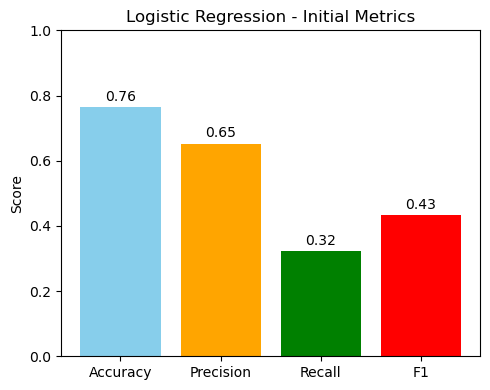

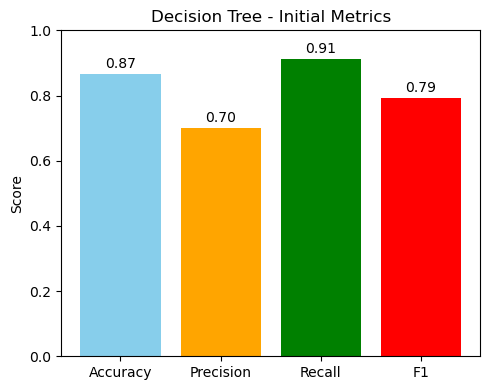

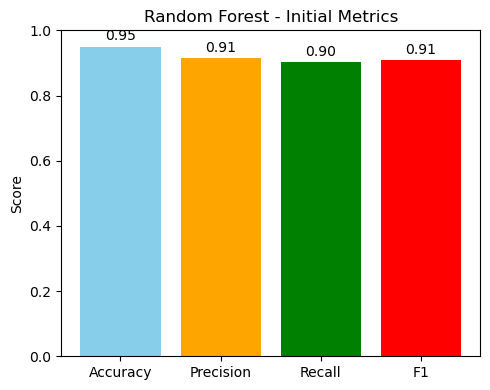

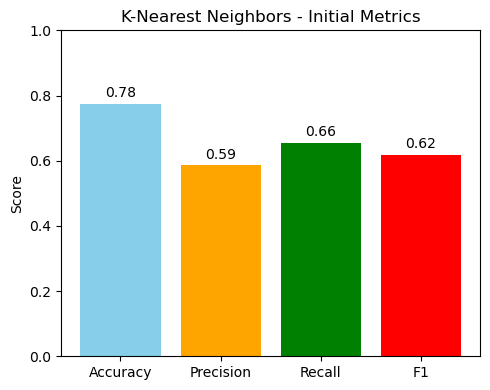

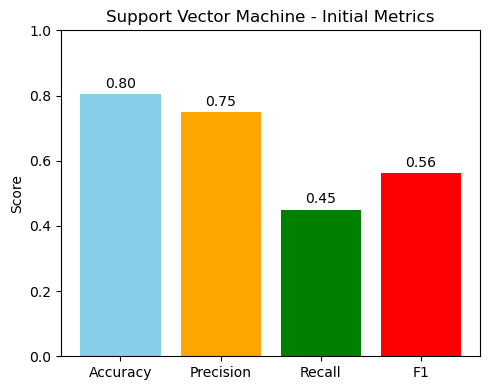

In [72]:
def plot_metrics_bar_chart(model_name, accuracy, precision, recall, f1):
    metrics = [accuracy, precision, recall, f1]
    labels = ['Accuracy', 'Precision', 'Recall', 'F1']
    
    x = np.arange(len(labels))
    plt.figure(figsize=(5, 4))  # Adjust figure size as needed
    bars = plt.bar(x, metrics, color=['skyblue', 'orange', 'green', 'red'])
    
    # Annotate each bar with its value
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2,
                 height + 0.01, 
                 f'{height:.2f}',
                 ha='center', va='bottom', fontsize=10)
    
    plt.ylim([0, 1])  # Since Accuracy/Precision/Recall/F1 are between 0-1
    plt.xticks(x, labels)
    plt.ylabel('Score')
    plt.title(f'{model_name} - Initial Metrics')
    plt.tight_layout()
    plt.show()


# Now call it for each model
plot_metrics_bar_chart(
    "Logistic Regression", 
    acc_log, prec_log, rec_log, f1_log
)

plot_metrics_bar_chart(
    "Decision Tree",
    acc_dt, prec_dt, rec_dt, f1_dt
)

plot_metrics_bar_chart(
    "Random Forest",
    acc_rf, prec_rf, rec_rf, f1_rf
)

plot_metrics_bar_chart(
    "K-Nearest Neighbors",
    acc_knn, prec_knn, rec_knn, f1_knn
)

plot_metrics_bar_chart(
    "Support Vector Machine",
    acc_svm, prec_svm, rec_svm, f1_svm
)

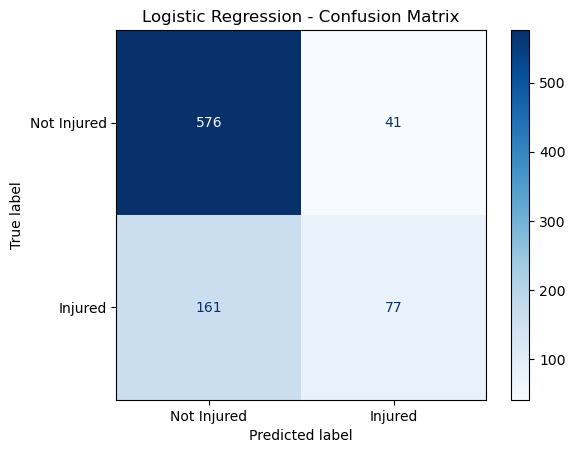

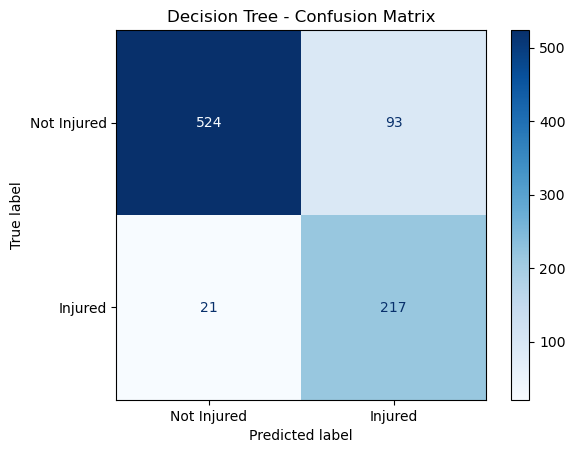

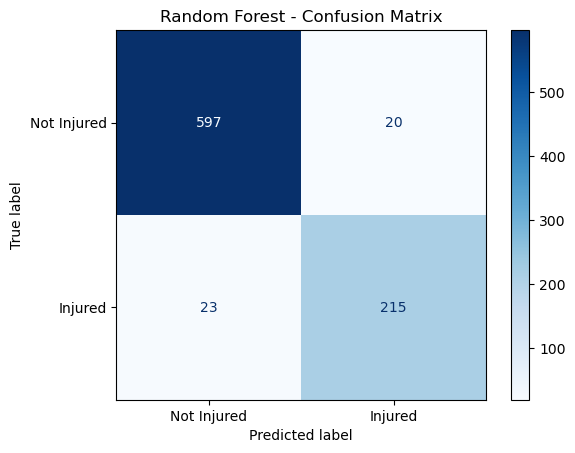

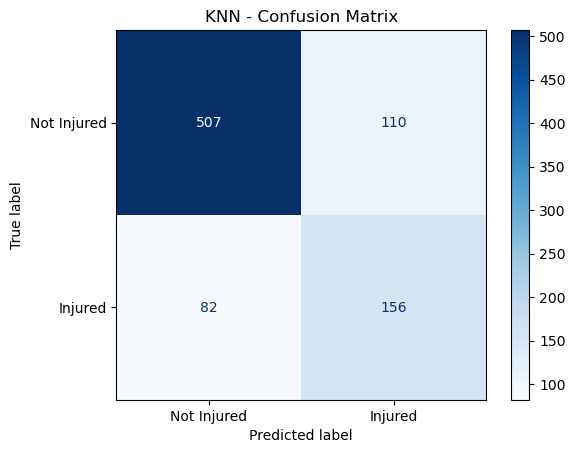

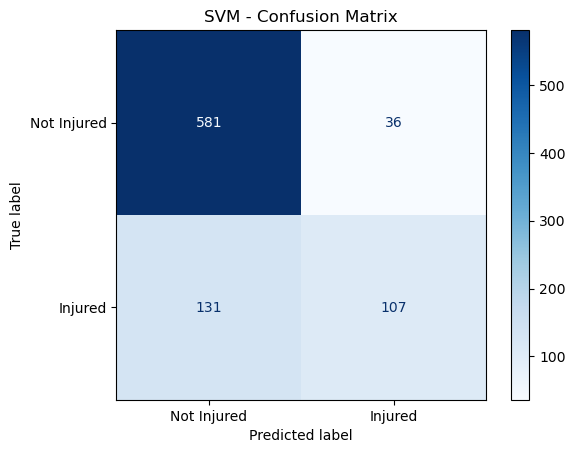

In [75]:

# Logistic Regression
ConfusionMatrixDisplay.from_estimator(
    logistic_pipeline,
    X_test, y_test,
    display_labels=['Not Injured', 'Injured'],
    cmap='Blues'
)
plt.title("Logistic Regression - Confusion Matrix")
plt.show()

# Decision Tree
ConfusionMatrixDisplay.from_estimator(
    decision_tree_pipeline,
    X_test, y_test,
    display_labels=['Not Injured', 'Injured'],
    cmap='Blues'
)
plt.title("Decision Tree - Confusion Matrix")
plt.show()

# Random Forest
ConfusionMatrixDisplay.from_estimator(
    random_forest_pipeline,
    X_test, y_test,
    display_labels=['Not Injured', 'Injured'],
    cmap='Blues'
)
plt.title("Random Forest - Confusion Matrix")
plt.show()

# K-Nearest Neighbors
ConfusionMatrixDisplay.from_estimator(
    knn_pipeline,
    X_test, y_test,
    display_labels=['Not Injured', 'Injured'],
    cmap='Blues'
)
plt.title("KNN - Confusion Matrix")
plt.show()

# Support Vector Machine
ConfusionMatrixDisplay.from_estimator(
    svm_pipeline,
    X_test, y_test,
    display_labels=['Not Injured', 'Injured'],
    cmap='Blues'
)
plt.title("SVM - Confusion Matrix")
plt.show()


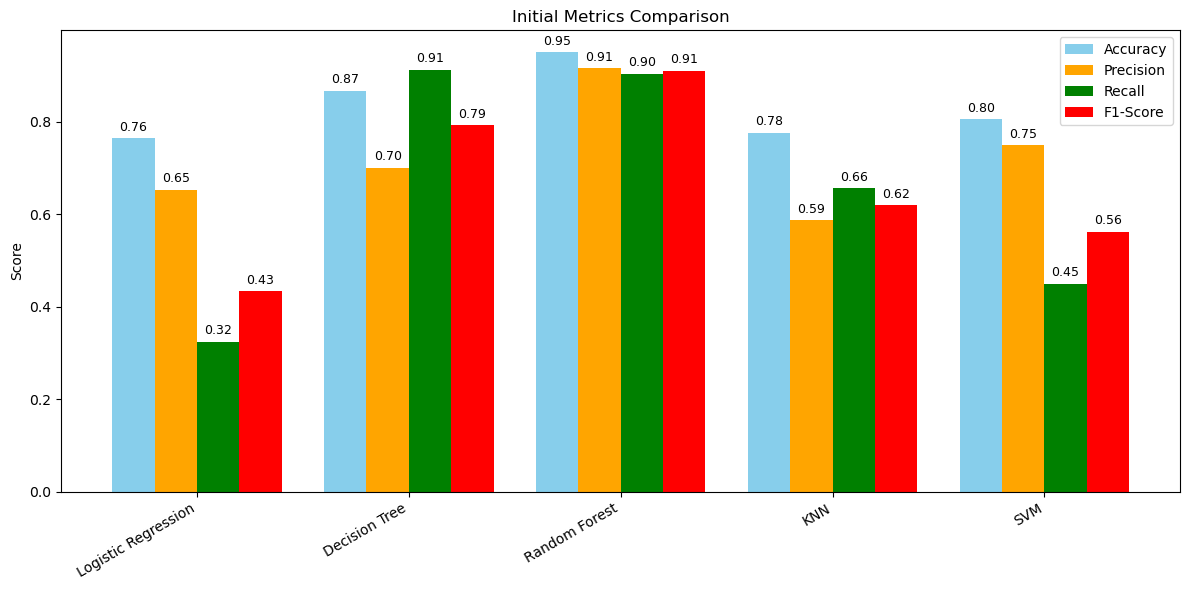

In [76]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'KNN', 'SVM']
initial_accuracy = [acc_log, acc_dt, acc_rf, acc_knn, acc_svm]
initial_precision = [prec_log, prec_dt, prec_rf, prec_knn, prec_svm]
initial_recall = [rec_log, rec_dt, rec_rf, rec_knn, rec_svm]
initial_f1 = [f1_log, f1_dt, f1_rf, f1_knn, f1_svm]

x = np.arange(len(models))
bar_width = 0.2

plt.figure(figsize=(12, 6))

# Plot each set of bars and save the returned container
bars_acc = plt.bar(x - 1.5*bar_width, initial_accuracy, 
                   width=bar_width, label='Accuracy', color='skyblue')
bars_prec = plt.bar(x - 0.5*bar_width, initial_precision, 
                    width=bar_width, label='Precision', color='orange')
bars_rec = plt.bar(x + 0.5*bar_width, initial_recall, 
                   width=bar_width, label='Recall', color='green')
bars_f1 = plt.bar(x + 1.5*bar_width, initial_f1, 
                  width=bar_width, label='F1-Score', color='red')

# Annotate each bar with its height
for bar_container in [bars_acc, bars_prec, bars_rec, bars_f1]:
    for bar in bar_container:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # X-coordinate
            height + 0.01,                     # Slightly above the bar
            f'{height:.2f}',                   # Format to 2 decimals
            ha='center', va='bottom', fontsize=9
        )

plt.xticks(x, models, rotation=30, ha='right')
plt.ylabel('Score')
plt.title('Initial Metrics Comparison')
plt.legend()
plt.tight_layout()
plt.show()


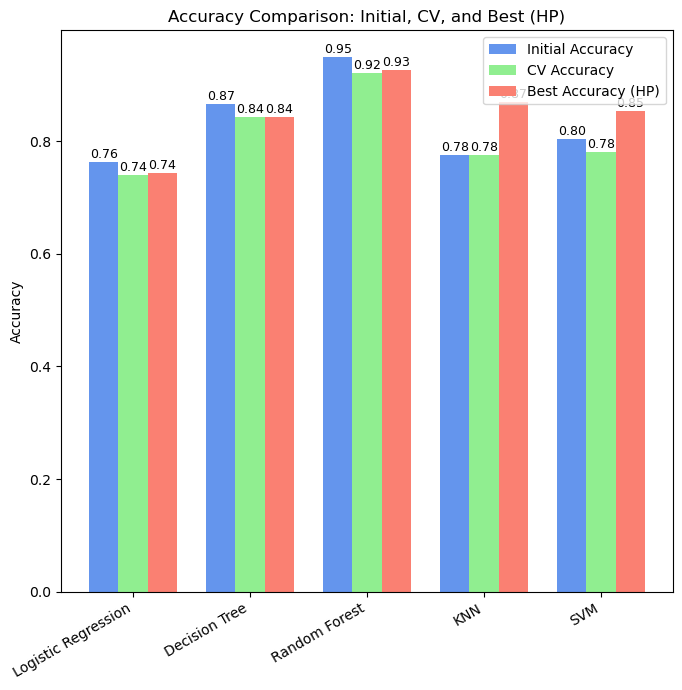

In [77]:
#VISUALIZE INITIAL vs CV vs BEST TUNED ACCURACY
init_accs = [acc_log, acc_dt, acc_rf, acc_knn, acc_svm]
cv_accs = [cv_acc_log, cv_acc_dt, cv_acc_rf, cv_acc_knn, cv_acc_svm]
best_accs = [best_acc_log, best_acc_dt, best_acc_rf, best_acc_knn, best_acc_svm]

x = np.arange(len(models))
bar_width = 0.25
plt.figure(figsize=(7, 7))

bars_init = plt.bar(x - bar_width, init_accs, width=bar_width, label='Initial Accuracy', color='cornflowerblue')
bars_cv   = plt.bar(x, cv_accs, width=bar_width, label='CV Accuracy', color='lightgreen')
bars_best = plt.bar(x + bar_width, best_accs, width=bar_width, label='Best Accuracy (HP)', color='salmon')

plt.xticks(x, models, rotation=30, ha='right')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison: Initial, CV, and Best (HP)')
plt.legend()
plt.tight_layout()

for bars in [bars_init, bars_cv, bars_best]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height+0.002,
                 f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.show()


In [78]:
models = list(cv_metrics.keys())
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']

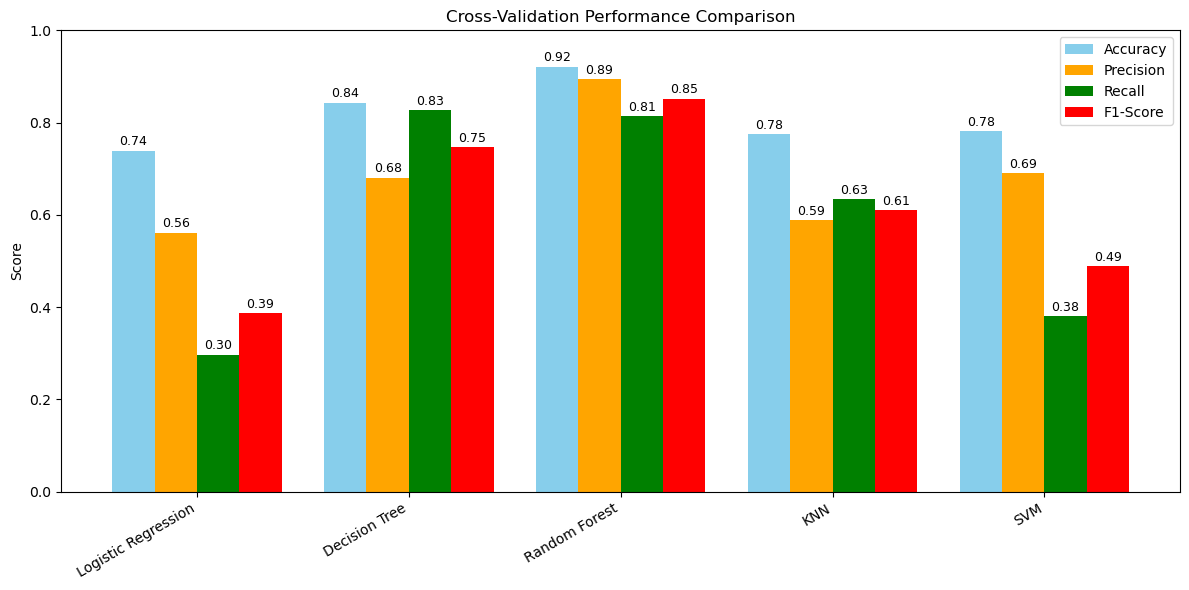

In [79]:
import matplotlib.pyplot as plt

x = np.arange(len(models))  # indices for each model
bar_width = 0.2

# We'll split the 4 metrics into separate bars per model
# (Accuracy, Precision, Recall, F1)
accuracy_values = [cv_metrics[m][0] for m in models]
precision_values = [cv_metrics[m][1] for m in models]
recall_values = [cv_metrics[m][2] for m in models]
f1_values = [cv_metrics[m][3] for m in models]

plt.figure(figsize=(12, 6))

bars_acc = plt.bar(x - 1.5*bar_width, accuracy_values, 
                   width=bar_width, label='Accuracy', color='skyblue')
bars_prec = plt.bar(x - 0.5*bar_width, precision_values, 
                    width=bar_width, label='Precision', color='orange')
bars_rec = plt.bar(x + 0.5*bar_width, recall_values, 
                   width=bar_width, label='Recall', color='green')
bars_f1 = plt.bar(x + 1.5*bar_width, f1_values, 
                  width=bar_width, label='F1-Score', color='red')

# Annotate each bar with its height (2 decimal places)
for bar_container in [bars_acc, bars_prec, bars_rec, bars_f1]:
    for bar in bar_container:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2, 
            height + 0.005, 
            f"{height:.2f}", 
            ha='center', va='bottom', fontsize=9
        )

plt.xticks(x, models, rotation=30, ha='right')
plt.ylabel('Score')
plt.ylim(0, 1)  # typical range for these metrics in [0, 1]
plt.title('Cross-Validation Performance Comparison')
plt.legend()
plt.tight_layout()
plt.show()
